In [ ]:
# This code subtracts off a PSF
# From a galaxy with a known AGN
# 205 - 1 is a good example of this
# I am trying to make a version of it that takes up less space on the SC (fully convolved etc)


In [1]:
view=1

In [2]:
# My new idea is to use one spaxel, an also to use a stellar template if necessary.
import pyfits
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


(2846, 67, 67)


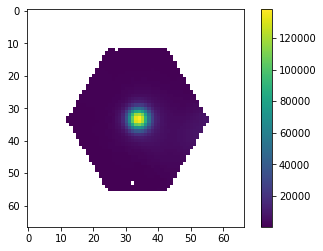

In [3]:
# The better way to do this is to construct a full 3D cube and work from there
small = pyfits.open('cubes/small_cube_alt_shape_fg3_m12_205_'+str(view)+'.fits')
print(np.shape(small[0].data))

summed_specs = np.sum(small[0].data, axis=0)
plt.imshow(ma.masked_where(summed_specs==0,summed_specs))
plt.colorbar()
plt.show()

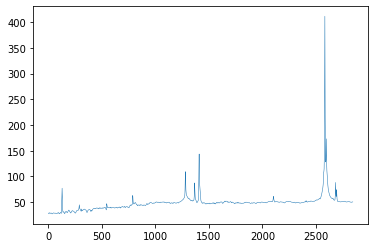

In [4]:
# The first step is to determine the brightest spaxel
coords = np.argwhere(summed_specs.max() == summed_specs)
plt.clf()
plt.plot(small[0].data[:,coords[0][0],coords[0][1]], label='Simulated Spectrum', lw=0.5)
plt.show()
# It has a lot of AGN contamination!

In [120]:
# Use the OG mcrx file to get the wavelength array
from scipy import signal
mcrx = pyfits.open('mcrx_205_agnx0.fits')
manga_wave = np.load('manga_wavelengths_AA.npy')

def find_idx(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

Ang=np.array([x[0]*10**(10) for x in mcrx[5].data])
#so I think this is in air wavelengths, we need to convert to vacuum                                                                             
s = 10**4/Ang
n = 1 + 0.00008336624212083 + 0.02408926869968 / (130.1065924522 - s**2) + 0.000159740894897 / (38.92568793293 - s**2)
Ang_vac = Ang*n
Ang = Ang_vac

new_Ang=[]
for p in range(10*len(Ang)):
    if p==0:
        starting_lambda=Ang[0]
    else:
        starting_lambda=starting_lambda+starting_lambda/2000
    new_Ang.append(starting_lambda)
    if starting_lambda > Ang[-1]:
        break

min_index=np.where(new_Ang==find_nearest(new_Ang,Ang[0]))[0][0]+1
max_index=np.where(new_Ang==find_nearest(new_Ang,Ang[-1]))[0][0]-1
new_Ang_wave=new_Ang[min_index:max_index-1]

min_index=np.where(manga_wave==find_nearest(manga_wave,new_Ang_wave[0]))[0][0]+1
max_index=np.where(manga_wave==find_nearest(manga_wave,new_Ang_wave[-1]))[0][0]-1
cut_manga_wave=manga_wave[min_index:max_index-1]

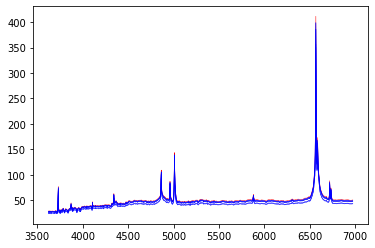

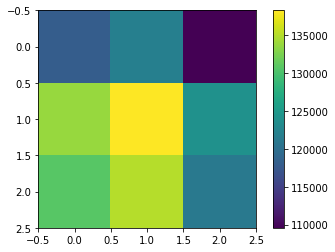

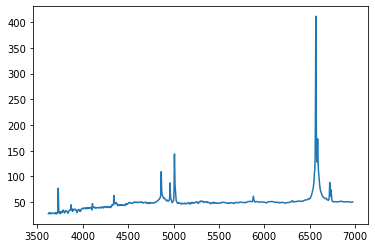

coordinates of center 33 34 value 138256.21196998522


In [187]:
# The first step is to determine the brightest spaxel
coords = np.argwhere(summed_specs.max() == summed_specs)
plt.clf()
plt.plot(cut_manga_wave, small[0].data[:,coords[0][0],coords[0][1]], label='Simulated Spectrum', lw=0.5, color='red')
plt.plot(cut_manga_wave, small[0].data[:,coords[0][0]+1,coords[0][1]-1], label='Simulated Spectrum', lw=0.5, color='blue')
plt.plot(cut_manga_wave, small[0].data[:,coords[0][0]+0,coords[0][1]-1], label='Simulated Spectrum', lw=0.5, color='blue')
plt.plot(cut_manga_wave, small[0].data[:,coords[0][0]-1,coords[0][1]-1], label='Simulated Spectrum', lw=0.5, color='blue')

plt.plot(cut_manga_wave, small[0].data[:,coords[0][0]+1,coords[0][1]+1], label='Simulated Spectrum', lw=0.5, color='blue')
plt.plot(cut_manga_wave, small[0].data[:,coords[0][0]+1,coords[0][1]+0], label='Simulated Spectrum', lw=0.5, color='blue')
plt.plot(cut_manga_wave, small[0].data[:,coords[0][0]+1,coords[0][1]-1], label='Simulated Spectrum', lw=0.5, color='blue')

#plt.xlim([5500,6000])
#plt.ylim([30,100])
plt.show()

#AGN will be a sum of the coadded central places

AGN = small[0].data[:,coords[0][0], coords[0][1]]
#np.sum(small[0].data[:,coords[0][0]-1:coords[0][0]+2,coords[0][1]-1:coords[0][1]+2], axis=(1,2))
plt.clf()
plt.imshow(np.sum(small[0].data[:,coords[0][0]-1:coords[0][0]+2,coords[0][1]-1:coords[0][1]+2], axis=0))
plt.colorbar()
plt.show()

plt.clf()
plt.plot(cut_manga_wave, AGN)
plt.show()

print('coordinates of center', coords[0][0],coords[0][1], 'value', np.sum(small[0].data[:,coords[0][0],coords[0][1]], axis=0))

[-2.92986063e-03  6.70669343e+01]


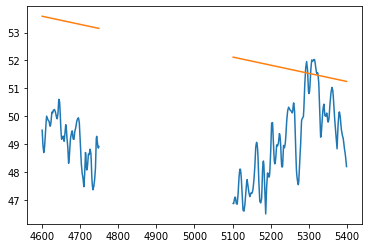

70053.84276153849
64225.3781584265
76991.06232811688
77722.34084047841
total hb flux 14605.717645518307


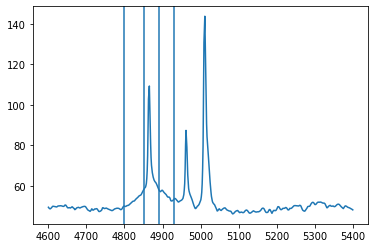

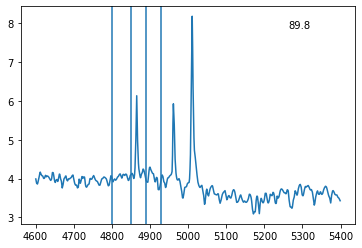

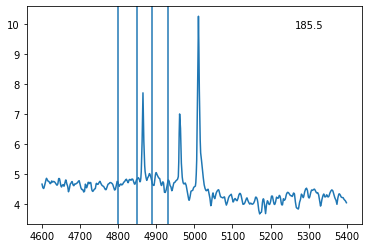

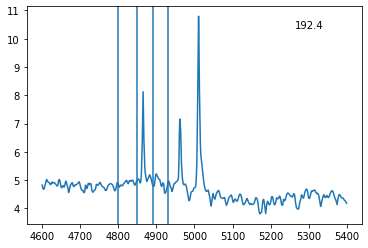

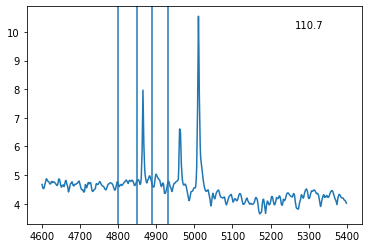

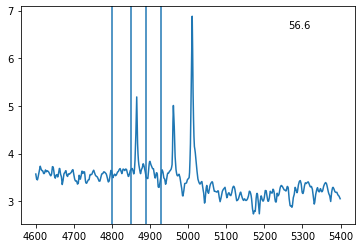

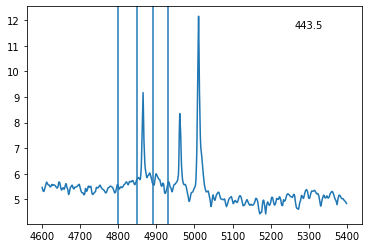

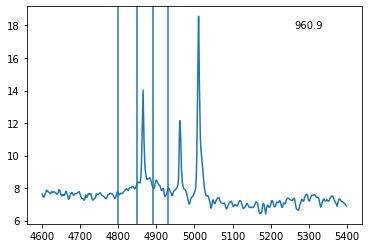

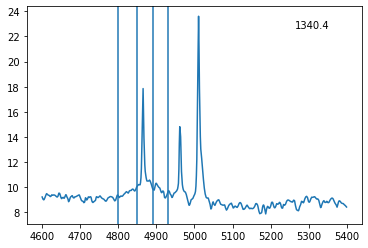

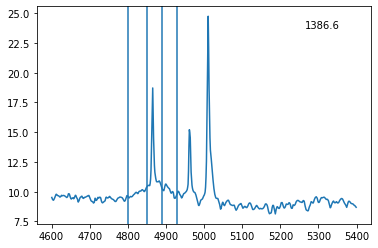

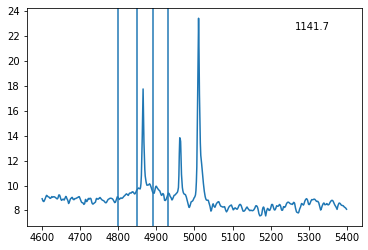

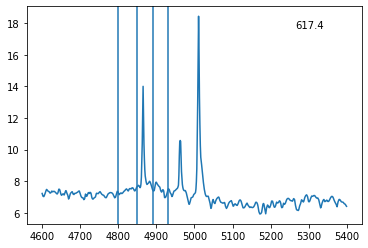

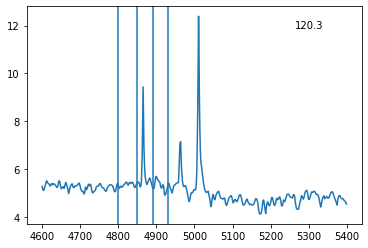

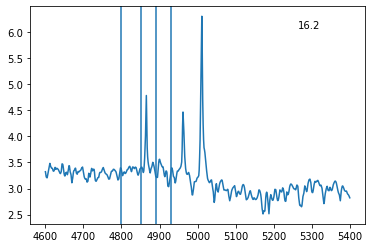

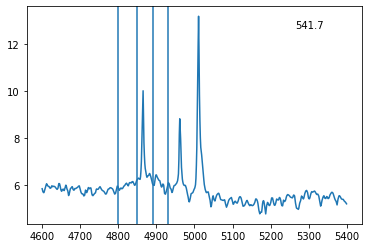

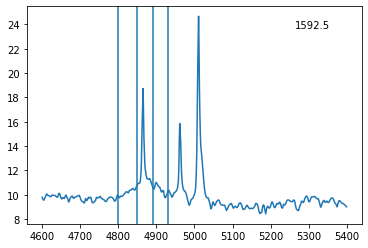

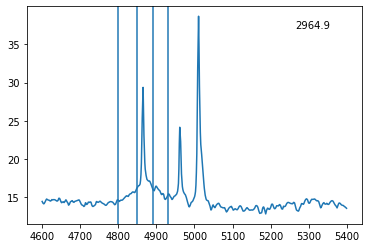

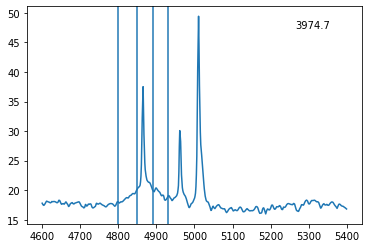

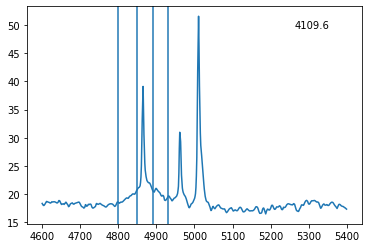

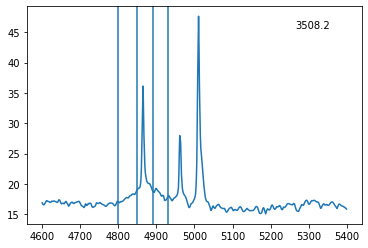

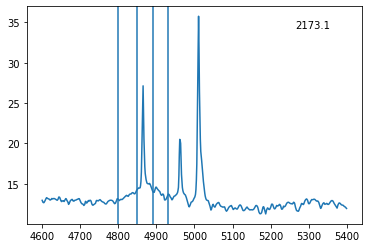

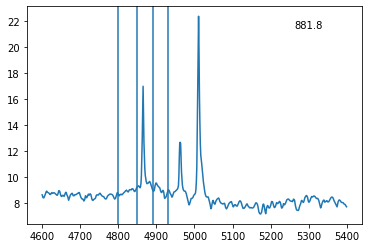

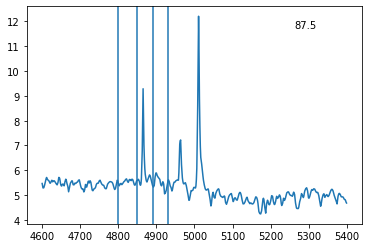

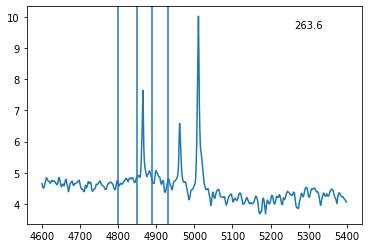

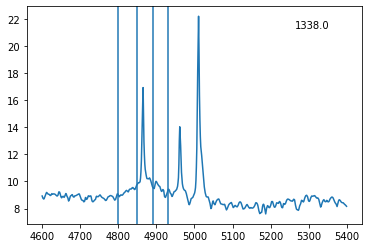

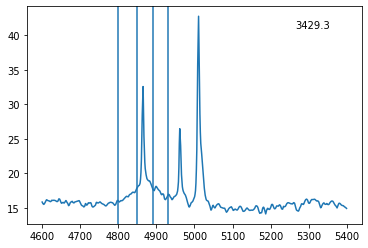

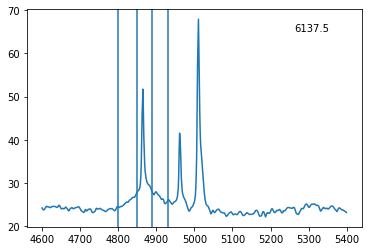

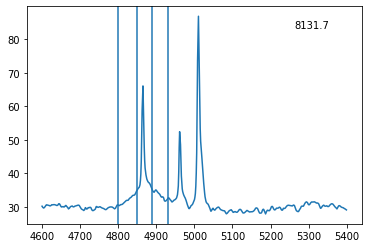

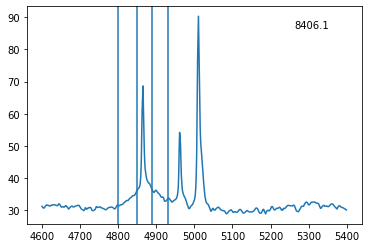

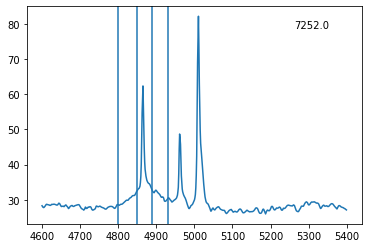

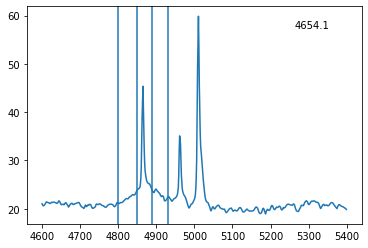

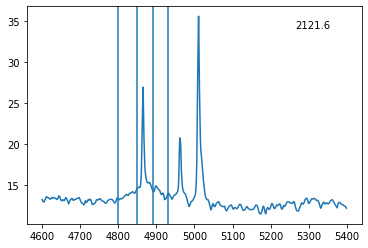

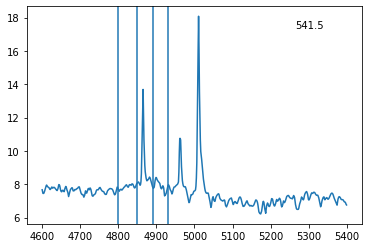

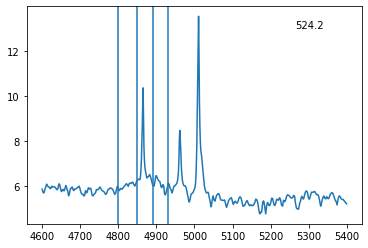

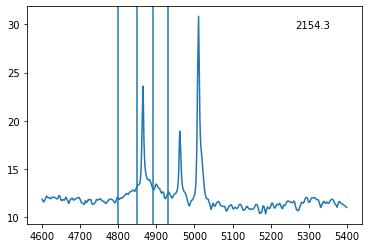

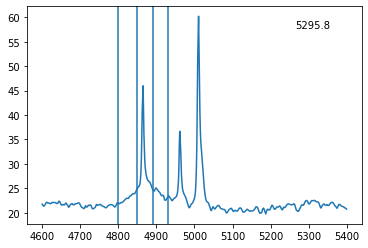

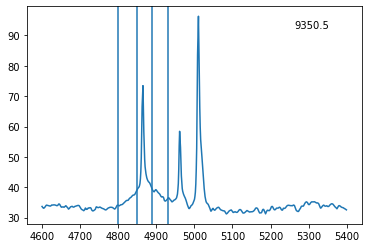

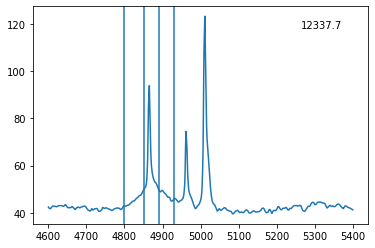

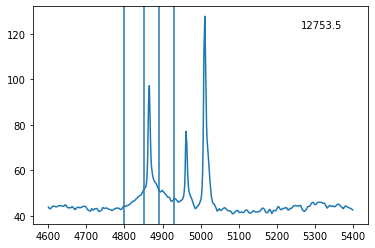

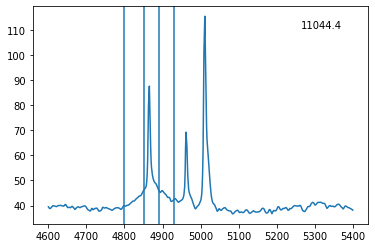

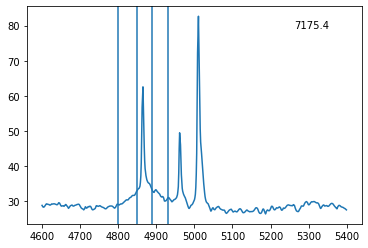

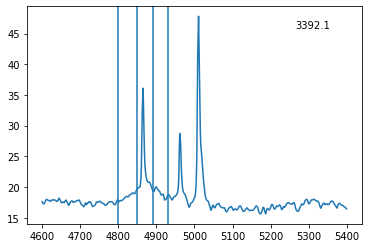

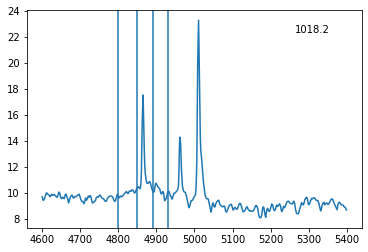

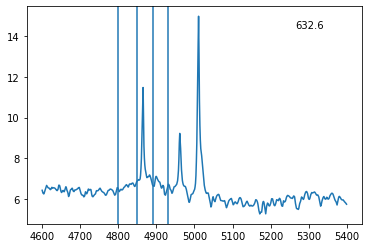

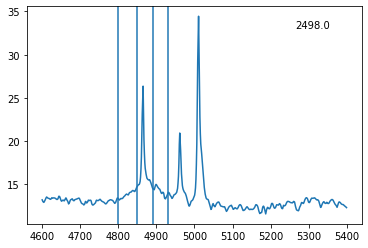

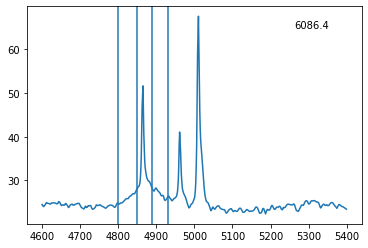

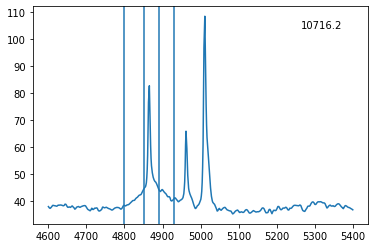

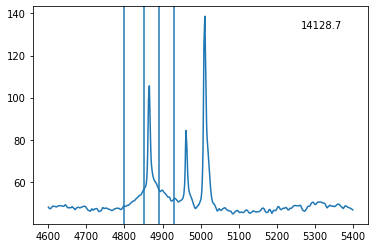

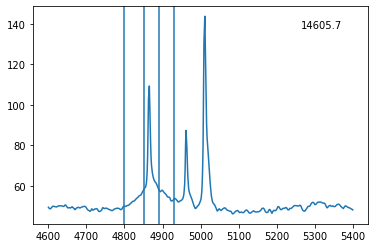

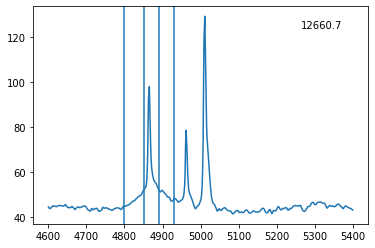

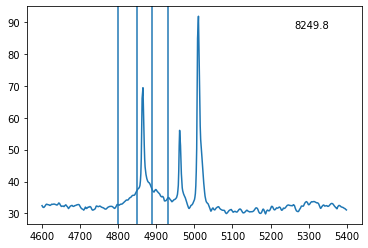

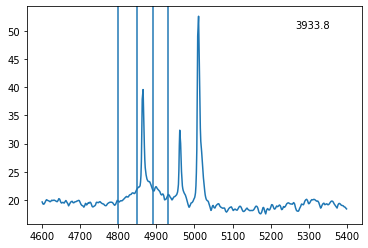

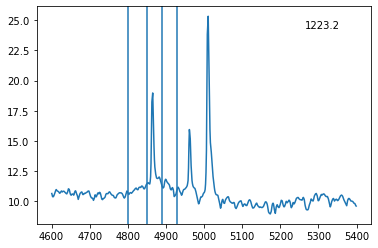

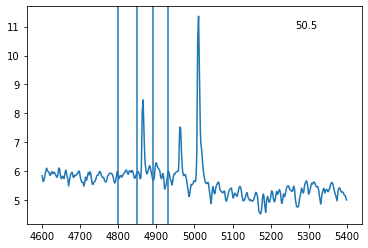

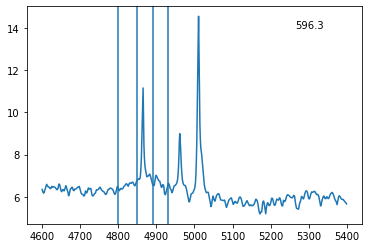

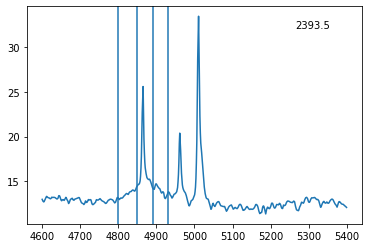

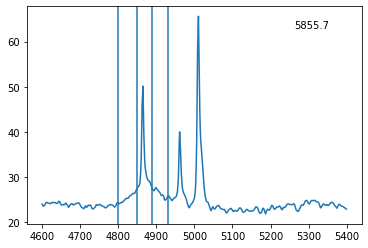

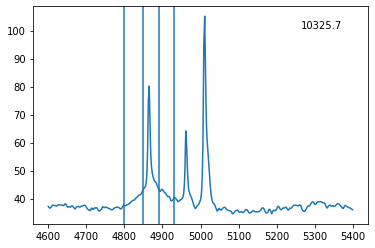

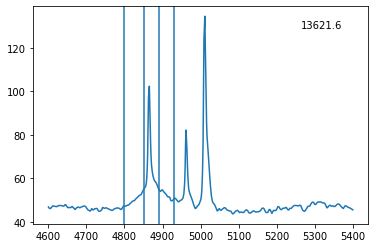

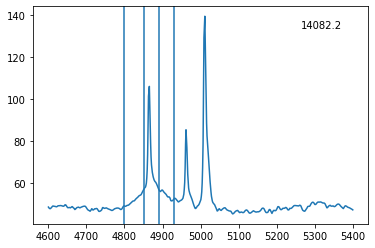

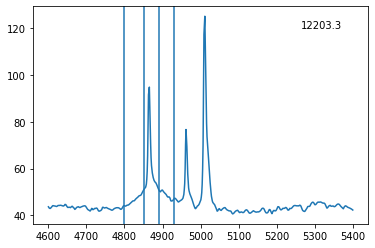

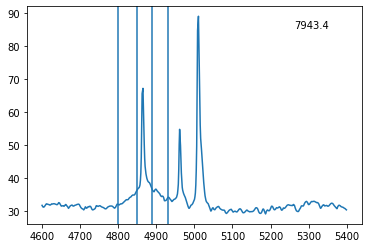

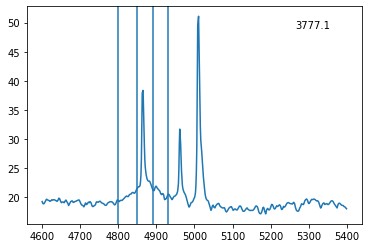

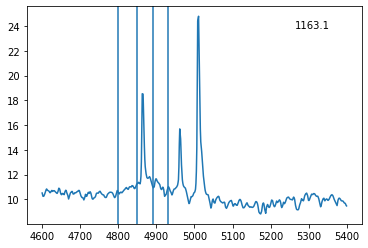

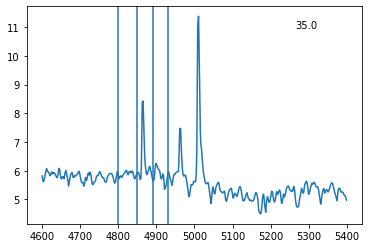

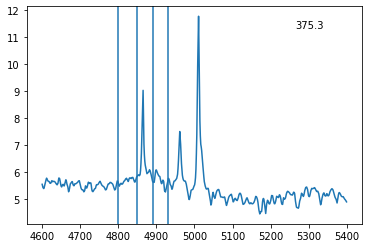

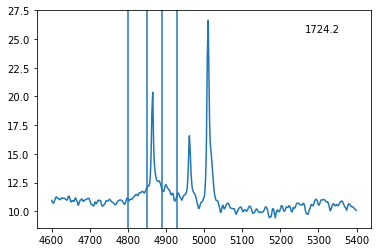

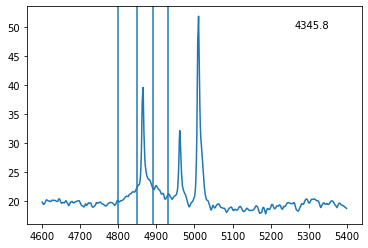

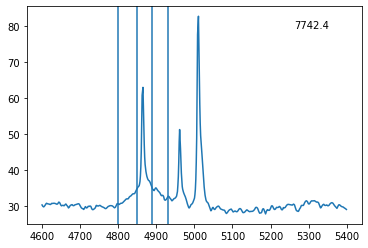

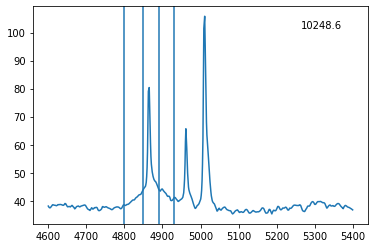

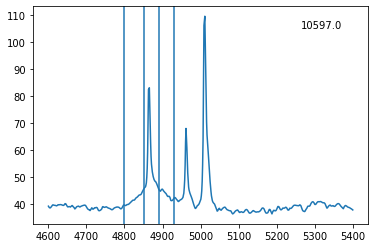

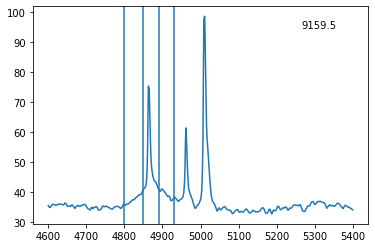

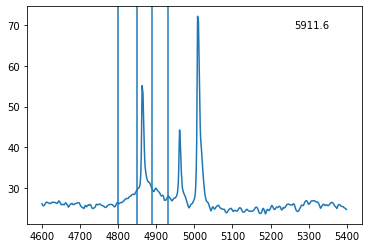

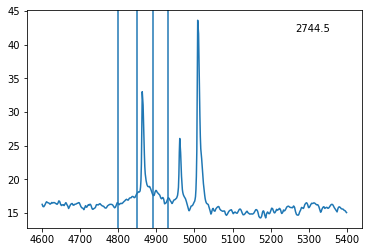

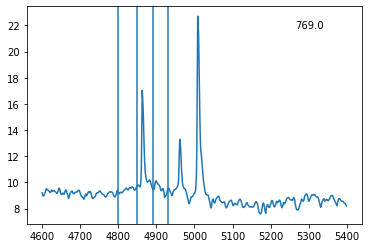

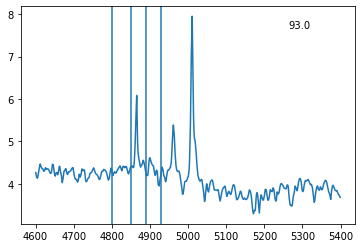

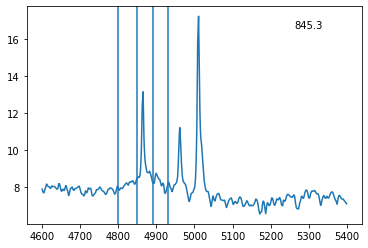

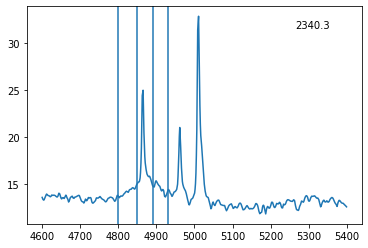

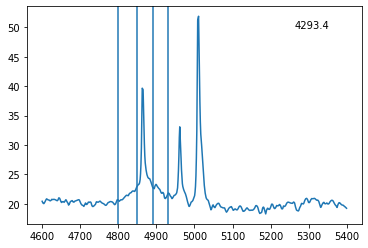

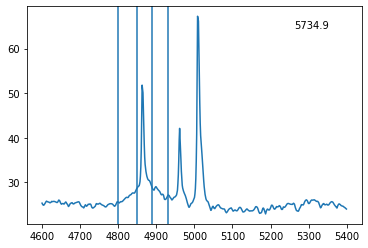

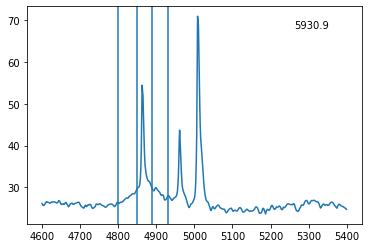

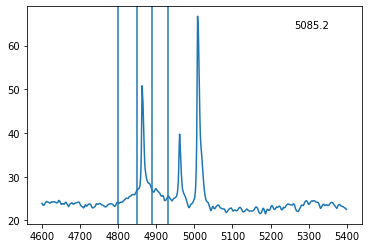

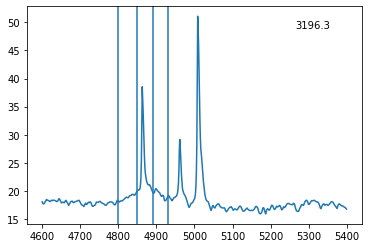

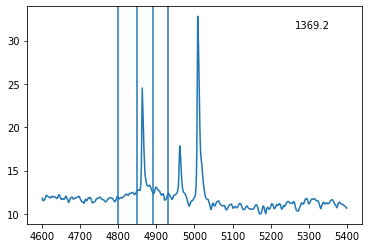

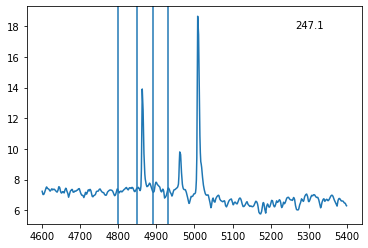

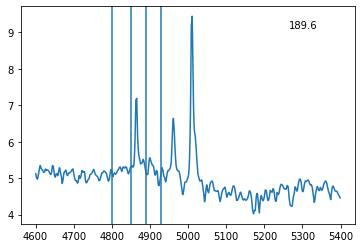

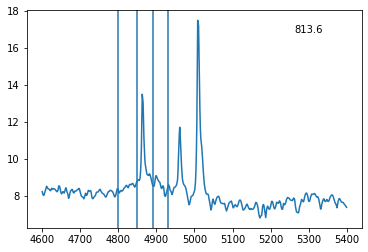

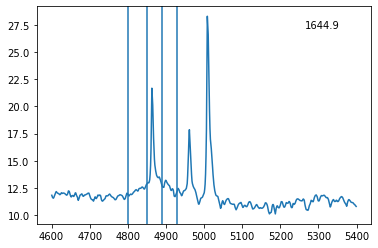

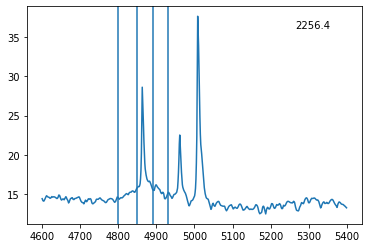

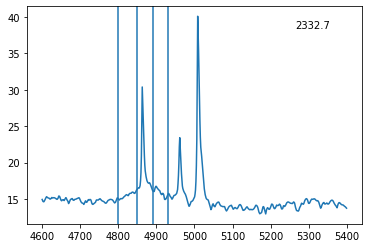

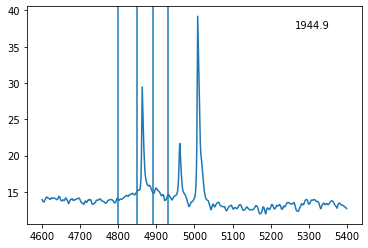

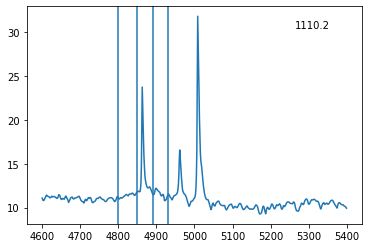

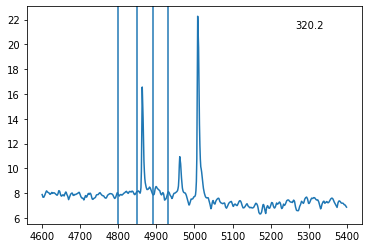

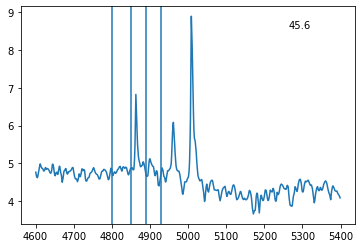

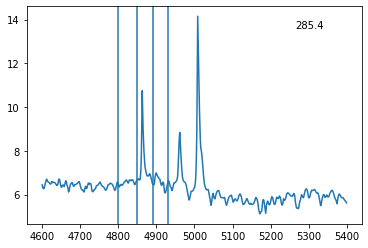

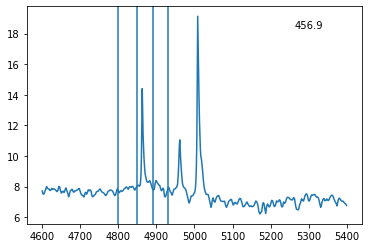

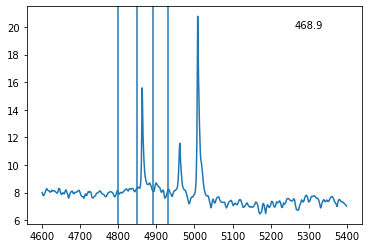

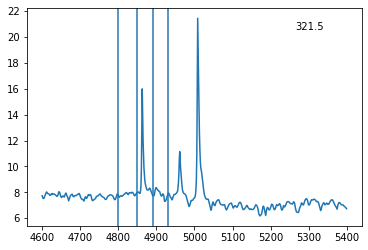

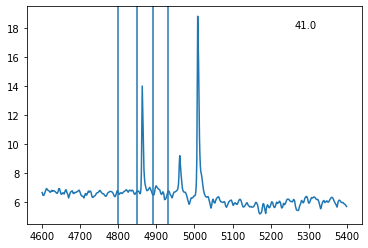

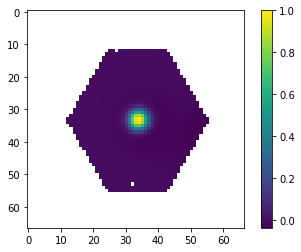

In [184]:
# Now determine s(x,y) based on the flux of h beta broad
central = small[0].data[:,coords[0][0],coords[0][1]]
idx_1_og = find_idx(cut_manga_wave, 4600)
idx_2_og = find_idx(cut_manga_wave, 5400)
idx_1 = idx_1_og
idx_2 = idx_2_og


# Fit the continuum on either side of these emission lines
x = cut_manga_wave[idx_1:idx_2]
x = ma.masked_inside(x, find_nearest(x, 4750), find_nearest(x, 5100))
#y = ma.masked_inside(central, central[find_idx(cut_manga_wave, 4750)], central[find_idx(cut_manga_wave, 5100)])

y = central[idx_1:idx_2]
#x = cut_manga_wave[idx_1:idx_2]

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
print(z)

from scipy.optimize import curve_fit

def f(x, A, B): # this is your 'straight line' y=f(x)
    return A*x + B

popt, pcov = curve_fit(f, x, y) # your data x, y to fit

plt.plot(x, y)
plt.plot(x, p(x))
plt.show()

idx_1 = find_idx(cut_manga_wave, 4760)
idx_2 = find_idx(cut_manga_wave, 4800)
flux_cont_1 = np.sum(central[idx_1:idx_2])*40
print(flux_cont_1)

idx_1 = find_idx(cut_manga_wave, 5100)
idx_2 = find_idx(cut_manga_wave, 5140)
flux_cont_2 = np.sum(central[idx_1:idx_2])*40
print(flux_cont_2)

# Then measure H beta flux
idx_1 = find_idx(cut_manga_wave, 4810)
idx_2 = find_idx(cut_manga_wave, 4850)
flux_hb_1 = np.sum(central[idx_1:idx_2])*40
print(flux_hb_1)

idx_1 = find_idx(cut_manga_wave, 4890)
idx_2 = find_idx(cut_manga_wave, 4930)
flux_hb_2 = np.sum(central[idx_1:idx_2])*40

print(flux_hb_2)

hb_flux = flux_hb_1 + flux_hb_2 - 2*flux_cont_1
print('total hb flux', hb_flux)
plt.clf()
plt.plot(cut_manga_wave[idx_1_og:idx_2_og], central[idx_1_og:idx_2_og])
plt.axvline(x=4800)
plt.axvline(x=4850)

plt.axvline(x=4890)
plt.axvline(x=4930)
plt.show()

# Now do this for every single spaxel
hb_flux = np.zeros((np.shape(small[0].data)[1], np.shape(small[0].data)[2]))
for j in range(np.shape(small[0].data)[1]):
    for i in range(np.shape(small[0].data)[2]):
        try:
            central = small[0].data[:,j,i]
        except IndexError:
            continue
        idx_1 = find_idx(cut_manga_wave, 4760)
        idx_2 = find_idx(cut_manga_wave, 4800)
        flux_cont_1 = np.sum(central[idx_1:idx_2])*40
        
        # Then measure H beta flux
        idx_1 = find_idx(cut_manga_wave, 4810)
        idx_2 = find_idx(cut_manga_wave, 4850)
        flux_hb_1 = np.sum(central[idx_1:idx_2])*40
        
        idx_1 = find_idx(cut_manga_wave, 4890)
        idx_2 = find_idx(cut_manga_wave, 4930)
        flux_hb_2 = np.sum(central[idx_1:idx_2])*40

        
        

        hb_flux_fill = flux_hb_1 + flux_hb_2 - 2*flux_cont_1
        hb_flux[j,i]=hb_flux_fill
        if hb_flux_fill ==0 or hb_flux_fill < 0:
            continue
        else:
            plt.clf()
            plt.plot(cut_manga_wave[idx_1_og:idx_2_og], central[idx_1_og:idx_2_og])
            plt.axvline(x=4800)
            plt.axvline(x=4850)
            plt.annotate(str(round(hb_flux_fill, 1)), xy=(0.8, 0.9), xycoords='axes fraction')
            plt.axvline(x=4890)
            plt.axvline(x=4930)
            plt.show()


kernel_hb = np.ma.masked_where(hb_flux==0, hb_flux)/np.max(np.ma.masked_where(hb_flux==0, hb_flux))
plt.clf()
plt.imshow(kernel_hb)
plt.colorbar()
plt.show()

sigma in arcsec 1.0615711252653928 0.5" per pixel 2.1231422505307855
2.1231422505307855


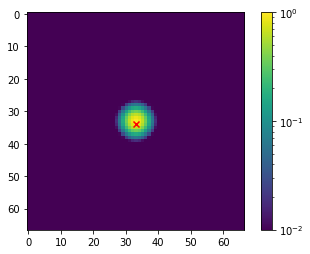

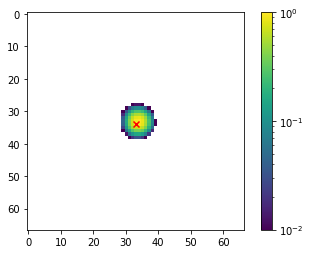

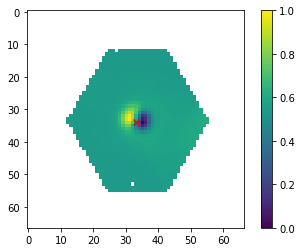

In [185]:
# Then, spread the light out according to the brightness of the PSF at that location.
from astropy.cosmology import WMAP9 as cosmo
from astropy.convolution import Gaussian2DKernel
import matplotlib

CAMERA0=mcrx[25+view]#25  
pixelscale=CAMERA0.header['CD1_1']
sigma = 2.5/2.355 #seeing is 2.5" FWHM, meaning that sigma is this many arcsec
# the spaxels are spaced by 0.5"/pix, so sigma is 5 pixels
print('sigma in arcsec', sigma, '0.5" per pixel', sigma/0.5)
kpc_arcmin=cosmo.kpc_proper_per_arcmin(0.03)

kernel_sigma_pix = sigma/0.5
#(sigma*(kpc_arcmin.value/60))/pixelscale                                                         

print(kernel_sigma_pix)
                                                                                                                

kernel = np.outer(signal.gaussian(67,kernel_sigma_pix), signal.gaussian(67, kernel_sigma_pix))
plt.imshow(kernel,  norm = matplotlib.colors.LogNorm(vmax=10**0, vmin=10**-2))#interpolation='none', origin='lower')
plt.colorbar()
plt.scatter(coords[0][0], coords[0][1], marker='x', color='red')

plt.show()

plt.imshow(kernel_hb, norm = matplotlib.colors.LogNorm(vmax=10**0, vmin=10**-2))
plt.colorbar()
plt.scatter(coords[0][0], coords[0][1], marker='x', color='red')

plt.show()

plt.imshow(kernel - kernel_hb)
plt.scatter(coords[0][0], coords[0][1], marker='x', color='red')
plt.colorbar()
plt.show()

(2846, 67, 67)


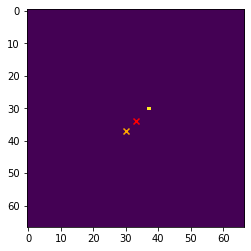

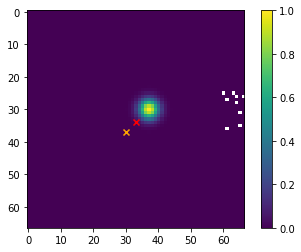

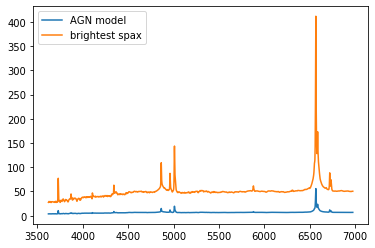

(2846, 67, 67)


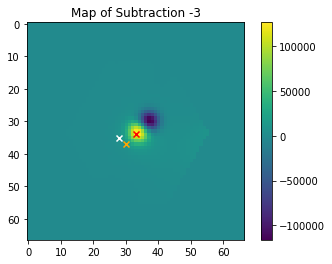

this is the value of the central spax 126787.4886038634
map of the surrounding spaxels


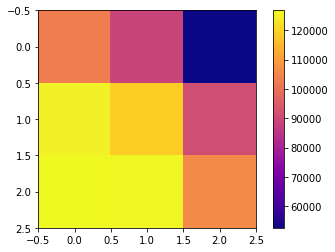

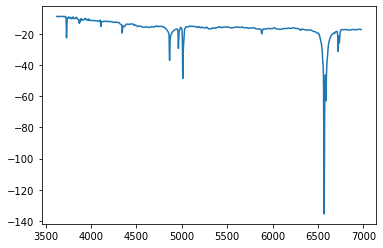

(2846, 67, 67)


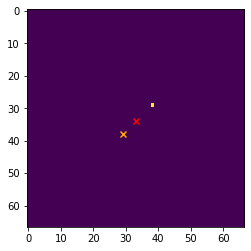

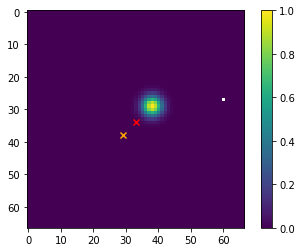

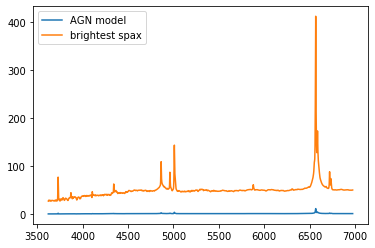

(2846, 67, 67)


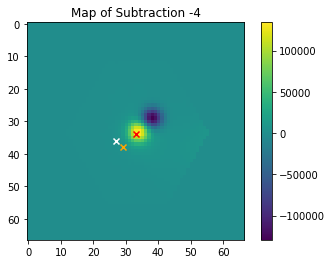

this is the value of the central spax 130221.4036918955
map of the surrounding spaxels


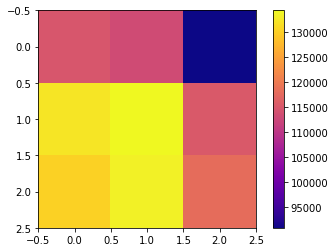

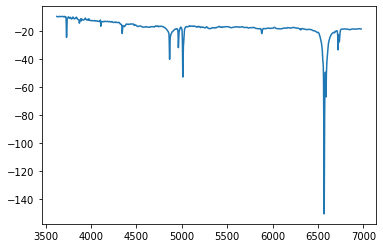

(2846, 67, 67)


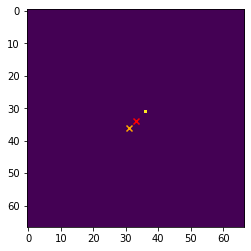

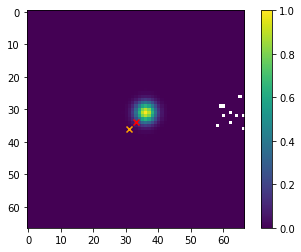

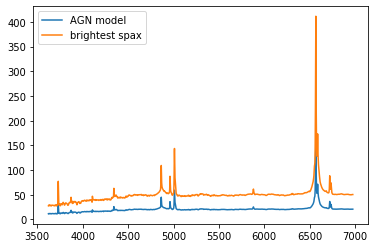

(2846, 67, 67)


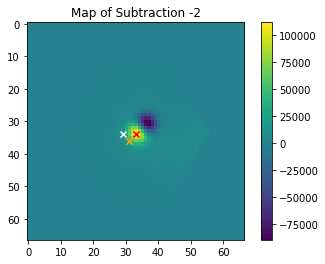

this is the value of the central spax 111985.75837004019
map of the surrounding spaxels


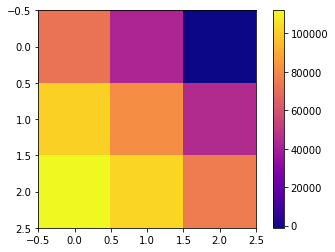

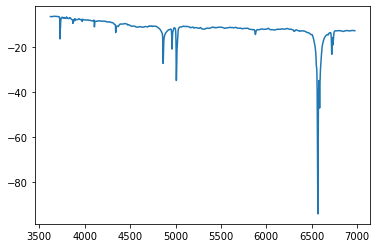

(2846, 67, 67)


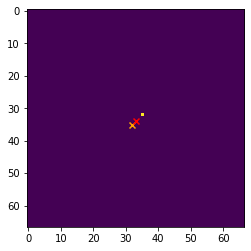

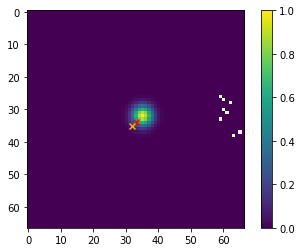

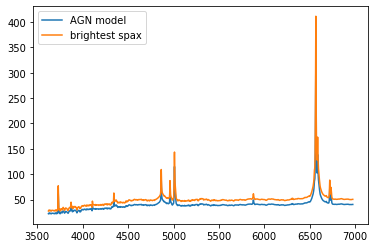

(2846, 67, 67)


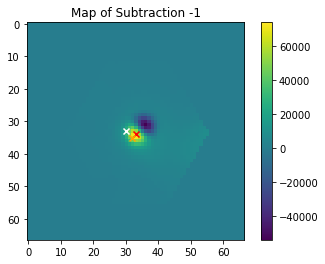

this is the value of the central spax 73835.44248622732
map of the surrounding spaxels


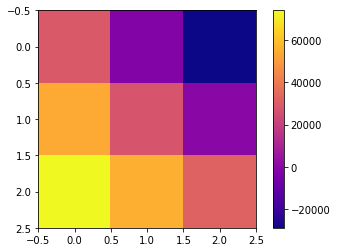

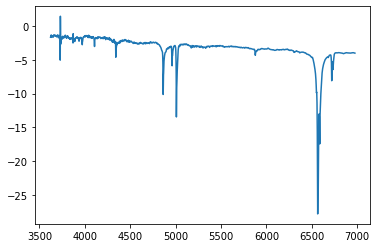

(2846, 67, 67)


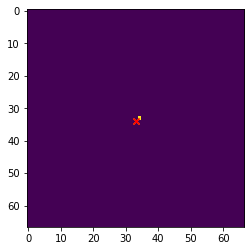

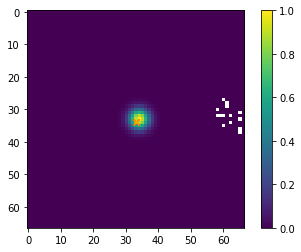

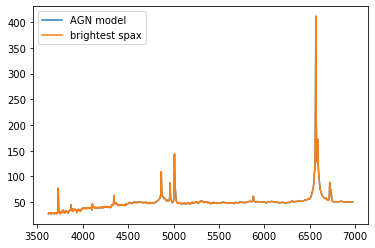

(2846, 67, 67)


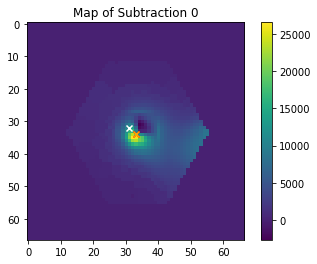

this is the value of the central spax 20011.877386547516
map of the surrounding spaxels


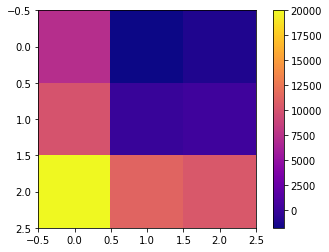

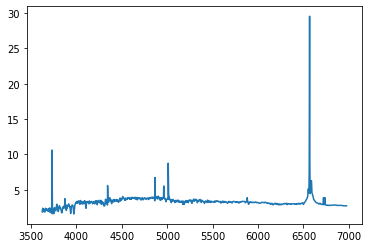

(2846, 67, 67)


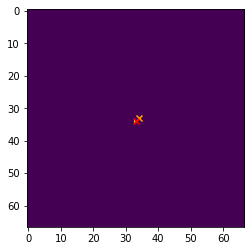

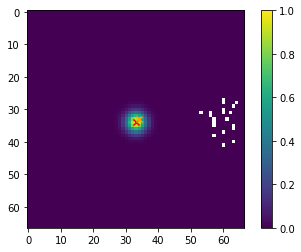

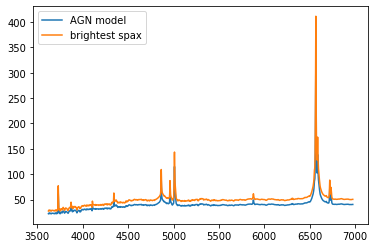

(2846, 67, 67)


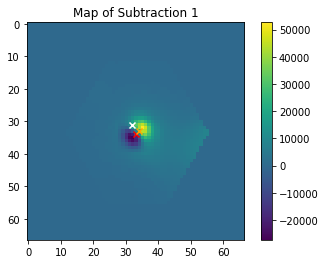

this is the value of the central spax -7495.202489814432
map of the surrounding spaxels


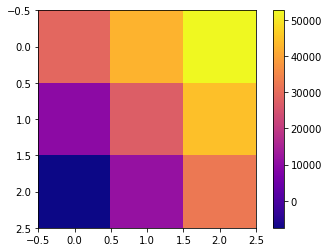

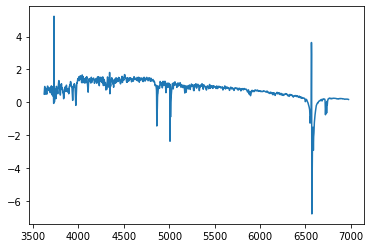

(2846, 67, 67)


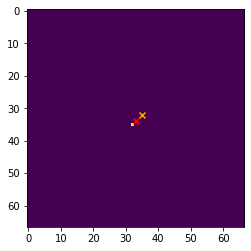

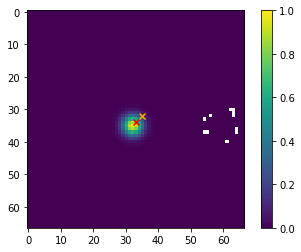

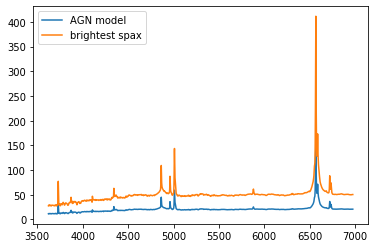

(2846, 67, 67)


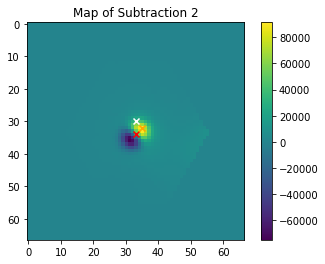

this is the value of the central spax 20011.877386547516
map of the surrounding spaxels


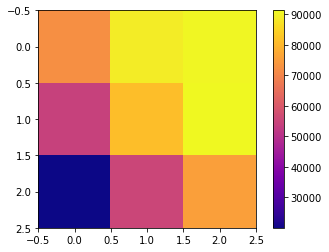

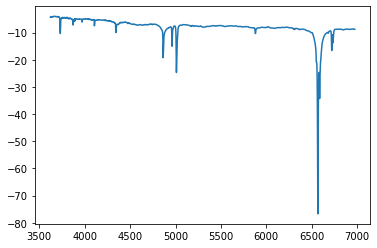

(2846, 67, 67)


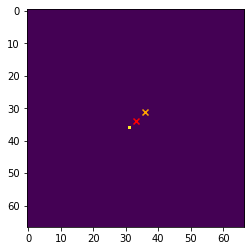

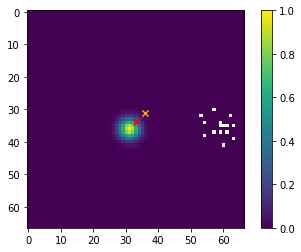

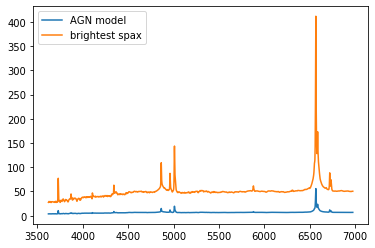

(2846, 67, 67)


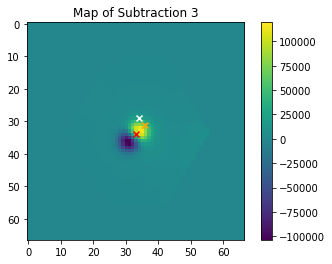

this is the value of the central spax 73835.44248622732
map of the surrounding spaxels


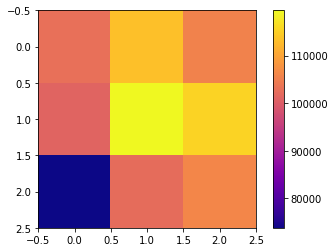

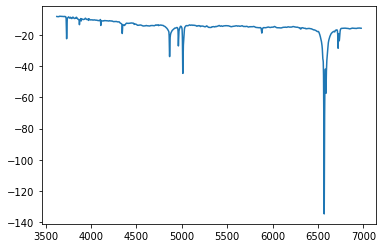

(2846, 67, 67)


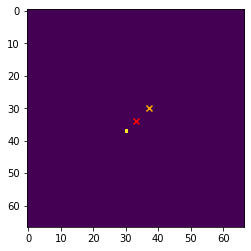

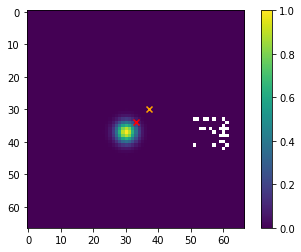

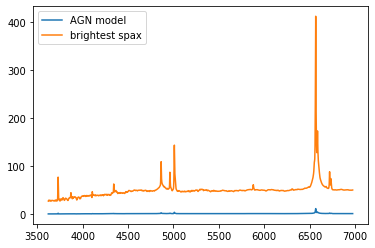

(2846, 67, 67)


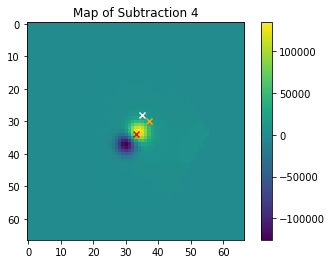

this is the value of the central spax 111985.75837004019
map of the surrounding spaxels


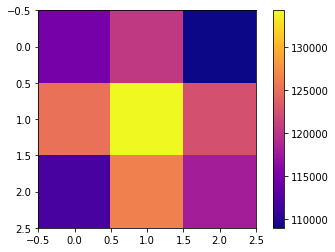

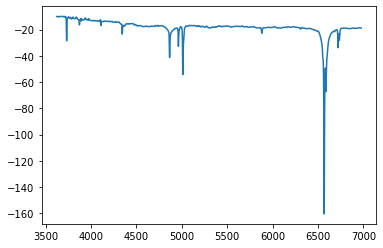

In [190]:
# Multiplication technique, first convolve so that the kernel is the proper size at one wavelength channel
shift = [-3,-4,-2,-1,0,1,2,3,4]
for p in range(len(shift)):
    shifty = shift[p]
    empty_gal = np.zeros((np.shape(small[0].data)[0], np.shape(small[0].data)[1], np.shape(small[0].data)[2]))

    empty_gal[:,coords[0][0]+shifty, coords[0][1]-shifty] = AGN
    print(np.shape(empty_gal))

    plt.clf()
    plt.imshow(np.sum(empty_gal, axis=0))
    plt.scatter(coords[0][0]+shifty,coords[0][1]-shifty, marker='x', color='orange')

    plt.scatter(coords[0][0],coords[0][1], marker='x', color='red')
    #plt.scatter(coords[0][0]+2,coords[0][1]-2, marker='x', color='purple')

    plt.show()






    conv = signal.fftconvolve(kernel, empty_gal[1000,:,:], mode='same')#kernel was gaussian_3D_kernel                             
    #kernel was - gaussian_2D_kernel.array/np.max(gaussian_2D_kernel.array)
    plt.imshow(ma.masked_where(conv==0, conv))
    plt.scatter(coords[0][0],coords[0][1], marker='x', color='red')
    plt.scatter(coords[0][0]+shifty,coords[0][1]-shifty, marker='x', color='orange')
    #plt.scatter(coords[0][0]+2,coords[0][1]-2, marker='x', color='purple')

    plt.colorbar()
    plt.show()

    '''empty_gal = np.zeros((np.shape(small[0].data)[0], np.shape(small[0].data)[1], np.shape(small[0].data)[2]))


    empty_gal[:,coords[0][0], coords[0][1]] = AGN
    conv = signal.fftconvolve(kernel, empty_gal[1000,:,:], mode='same')#kernel was gaussian_3D_kernel                             
    #kernel was - gaussian_2D_kernel.array/np.max(gaussian_2D_kernel.array)
    plt.imshow(ma.masked_where(conv==0, conv))
    plt.scatter(coords[0][0],coords[0][1], marker='x', color='red')
    plt.scatter(coords[0][0]+1,coords[0][1]-1, marker='x', color='orange')
    plt.scatter(coords[0][0]+2,coords[0][1]-2, marker='x', color='purple')

    plt.colorbar()
    plt.show()'''

    '''empty_gal = np.zeros((np.shape(small[0].data)[0], np.shape(small[0].data)[1], np.shape(small[0].data)[2]))


    empty_gal[:,coords[0][0]+2, coords[0][1]-2] = AGN
    conv = signal.fftconvolve(kernel, empty_gal[1000,:,:], mode='same')#kernel was gaussian_3D_kernel                             
    #kernel was - gaussian_2D_kernel.array/np.max(gaussian_2D_kernel.array)
    plt.imshow(ma.masked_where(conv==0, conv))
    plt.scatter(coords[0][0],coords[0][1], marker='x', color='red')
    plt.scatter(coords[0][0]+1,coords[0][1]-1, marker='x', color='orange')
    plt.scatter(coords[0][0]+2,coords[0][1]-2, marker='x', color='purple')

    plt.colorbar()
    plt.show()


    STOP'''
    # Repeat this at each individual wavelength so that you have your model AGN
    AGN_mod = np.zeros((np.shape(small[0].data)[0], np.shape(conv)[1], np.shape(conv)[1]))
    # It is okay that it has larger dimensions

    for j in range(len(cut_manga_wave)):
        AGN_mod[j,:,:] = signal.fftconvolve(kernel, empty_gal[j,:,:], mode='same')#kernel was gaussian_3D_kernel                             
    
                   
    plt.clf()
    plt.plot(cut_manga_wave, AGN_mod[:,coords[0][0],coords[0][1]], label='AGN model')
    plt.plot(cut_manga_wave, small[0].data[:,coords[0][0],coords[0][1]], label='brightest spax')
    plt.legend()
    plt.show()

    '''plt.clf()
    plt.plot(cut_manga_wave, AGN_mod[:,coords[0][0],coords[0][1]], label='AGN')
    plt.plot(cut_manga_wave, small[0].data[:,coords[0][0],coords[0][1]], label='Actual Spectrum')
    plt.legend()
    plt.ylim([0,50])
    plt.show()

    plt.clf()
    plt.plot(cut_manga_wave, small[0].data[:,coords[0][0]+3,coords[0][1]]-AGN_mod[:,coords[0][0]+3,coords[0][1]], label='Residual')
    #plt.plot(cut_manga_wave, small[0].data[:,coords[0][0]+3,coords[0][1]], label='Actual Spectrum')
    plt.legend()
    #plt.ylim([0,20])
    plt.show()

    # This is the brightest spaxel: small[0].data[:,coords[0][0],coords[0][1]]
    # First need to clip the AGN_mod to certain dimensions
    plt.imshow(np.sum(AGN_mod, axis=0), norm=matplotlib.colors.LogNorm())
    plt.colorbar()
    plt.scatter(coords[0][0], coords[0][1], marker='x', color='red')
    plt.title('AGN model')
    plt.savefig('AGN_model.png', dpi=1000)'''
    #plt.show()

    initial_subtraction = small[0].data - AGN_mod
    print(np.shape(initial_subtraction))

    plt.clf()
    plt.imshow(np.ma.masked_where((np.sum(initial_subtraction, axis=0))==0, (np.sum(initial_subtraction, axis=0))))#, norm=matplotlib.colors.LogNorm())
    plt.colorbar()
    plt.scatter(coords[0][0], coords[0][1], marker='x', color='red')
    plt.scatter(coords[0][0]+shifty, coords[0][1]-shifty, marker='x', color='orange')
    plt.scatter(coords[0][0]+shifty-2, coords[0][1]-shifty-2, marker='x', color='white')
    
    plt.title('Map of Subtraction '+str(shifty))
    plt.show()

# So after the initial subtraction, there is some over-subtraction
    print('this is the value of the central spax', np.sum(initial_subtraction[:,coords[0][0]+1, coords[0][1]-1], axis=0))

    print('map of the surrounding spaxels')
    plt.clf()
    plt.imshow(np.sum(initial_subtraction[:,coords[0][0]-1:coords[0][0]+2,coords[0][1]-1:coords[0][1]+2], axis=0), cmap='plasma')
    plt.colorbar()
    plt.show()
    
    plt.clf()
    plt.plot(cut_manga_wave, initial_subtraction[:,coords[0][0]+shifty-2, coords[0][1]-shifty-2])
    plt.show()

(2846, 67, 67)


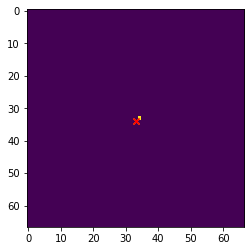

ValueError: operands could not be broadcast together with shapes (67,67) (2846,) 

In [195]:
# Multiplication technique, first convolve so that the kernel is the proper size at one wavelength channel
shifty = 0
empty_gal = np.zeros((np.shape(small[0].data)[0], np.shape(small[0].data)[1], np.shape(small[0].data)[2]))


empty_gal[:,coords[0][0], coords[0][1]] = AGN
print(np.shape(empty_gal))

plt.clf()
plt.imshow(np.sum(empty_gal, axis=0))
plt.scatter(coords[0][0]+shifty,coords[0][1]-shifty, marker='x', color='orange')

plt.scatter(coords[0][0],coords[0][1], marker='x', color='red')
#plt.scatter(coords[0][0]+2,coords[0][1]-2, marker='x', color='purple')

plt.show()






conv = kernel_hb*AGN#signal.fftconvolve(kernel_hb, empty_gal[1000,:,:], mode='same')#kernel was gaussian_3D_kernel                             
#kernel was - gaussian_2D_kernel.array/np.max(gaussian_2D_kernel.array)
plt.imshow(ma.masked_where(conv==0, conv))
plt.scatter(coords[0][0],coords[0][1], marker='x', color='red')
plt.scatter(coords[0][0]+shifty,coords[0][1]-shifty, marker='x', color='orange')
#plt.scatter(coords[0][0]+2,coords[0][1]-2, marker='x', color='purple')

plt.colorbar()
plt.show()

'''empty_gal = np.zeros((np.shape(small[0].data)[0], np.shape(small[0].data)[1], np.shape(small[0].data)[2]))


empty_gal[:,coords[0][0], coords[0][1]] = AGN
conv = signal.fftconvolve(kernel, empty_gal[1000,:,:], mode='same')#kernel was gaussian_3D_kernel                             
#kernel was - gaussian_2D_kernel.array/np.max(gaussian_2D_kernel.array)
plt.imshow(ma.masked_where(conv==0, conv))
plt.scatter(coords[0][0],coords[0][1], marker='x', color='red')
plt.scatter(coords[0][0]+1,coords[0][1]-1, marker='x', color='orange')
plt.scatter(coords[0][0]+2,coords[0][1]-2, marker='x', color='purple')

plt.colorbar()
plt.show()'''

'''empty_gal = np.zeros((np.shape(small[0].data)[0], np.shape(small[0].data)[1], np.shape(small[0].data)[2]))


empty_gal[:,coords[0][0]+2, coords[0][1]-2] = AGN
conv = signal.fftconvolve(kernel, empty_gal[1000,:,:], mode='same')#kernel was gaussian_3D_kernel                             
#kernel was - gaussian_2D_kernel.array/np.max(gaussian_2D_kernel.array)
plt.imshow(ma.masked_where(conv==0, conv))
plt.scatter(coords[0][0],coords[0][1], marker='x', color='red')
plt.scatter(coords[0][0]+1,coords[0][1]-1, marker='x', color='orange')
plt.scatter(coords[0][0]+2,coords[0][1]-2, marker='x', color='purple')

plt.colorbar()
plt.show()


STOP'''
# Repeat this at each individual wavelength so that you have your model AGN
AGN_mod = np.zeros((np.shape(small[0].data)[0], np.shape(conv)[1], np.shape(conv)[1]))
# It is okay that it has larger dimensions

for j in range(len(cut_manga_wave)):
    AGN_mod[j,:,:] = signal.fftconvolve(kernel_hb, empty_gal[j,:,:], mode='same')#kernel was gaussian_3D_kernel                             


plt.clf()
plt.plot(cut_manga_wave, AGN_mod[:,coords[0][0],coords[0][1]], label='AGN model')
plt.plot(cut_manga_wave, small[0].data[:,coords[0][0],coords[0][1]], label='brightest spax')
plt.legend()
plt.show()

plt.clf()
plt.plot(cut_manga_wave, small[0].data[:,coords[0][0],coords[0][1]]-AGN_mod[:,coords[0][0],coords[0][1]], label='Total Sub')
plt.legend()
plt.show()

'''plt.clf()
plt.plot(cut_manga_wave, AGN_mod[:,coords[0][0],coords[0][1]], label='AGN')
plt.plot(cut_manga_wave, small[0].data[:,coords[0][0],coords[0][1]], label='Actual Spectrum')
plt.legend()
plt.ylim([0,50])
plt.show()

plt.clf()
plt.plot(cut_manga_wave, small[0].data[:,coords[0][0]+3,coords[0][1]]-AGN_mod[:,coords[0][0]+3,coords[0][1]], label='Residual')
#plt.plot(cut_manga_wave, small[0].data[:,coords[0][0]+3,coords[0][1]], label='Actual Spectrum')
plt.legend()
#plt.ylim([0,20])
plt.show()

# This is the brightest spaxel: small[0].data[:,coords[0][0],coords[0][1]]
# First need to clip the AGN_mod to certain dimensions
plt.imshow(np.sum(AGN_mod, axis=0), norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.scatter(coords[0][0], coords[0][1], marker='x', color='red')
plt.title('AGN model')
plt.savefig('AGN_model.png', dpi=1000)'''
#plt.show()

initial_subtraction = small[0].data - AGN_mod
print(np.shape(initial_subtraction))

plt.clf()
plt.imshow(np.ma.masked_where((np.sum(initial_subtraction, axis=0))==0, (np.sum(initial_subtraction, axis=0))))#, norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.scatter(coords[0][0], coords[0][1], marker='x', color='red')
plt.scatter(coords[0][0]+shifty, coords[0][1]-shifty, marker='x', color='orange')
plt.scatter(coords[0][0]+shifty-2, coords[0][1]-shifty-2, marker='x', color='white')

plt.title('Map of Subtraction '+str(shifty))
plt.show()

# So after the initial subtraction, there is some over-subtraction
print('this is the value of the central spax', np.sum(initial_subtraction[:,coords[0][0]+1, coords[0][1]-1], axis=0))

print('map of the surrounding spaxels')
plt.clf()
plt.imshow(np.sum(initial_subtraction[:,coords[0][0]-1:coords[0][0]+1,coords[0][1]-1:coords[0][1]+1], axis=0), cmap='RdBu_r')

plt.colorbar()
plt.show()


# Check all of the surrounding spaxels
shifted=[-10,-3,-2,-1,0,1,2,3,10]
for p in range(len(shifted)):
    plt.clf()
    plt.plot(cut_manga_wave, small[0].data[:,coords[0][0]+shifted[p], coords[0][1]+shifted[p]], label='Before sub')
    
    plt.plot(cut_manga_wave, initial_subtraction[:,coords[0][0]+shifted[p], coords[0][1]+shifted[p]])
    plt.legend()
    plt.xlim([3500,4000])
    plt.show()

/Users/beckynevin/CfA_Code/AGN_Subtraction


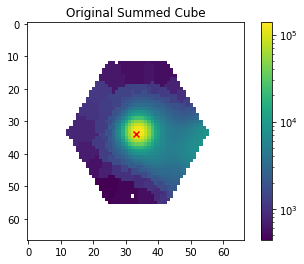

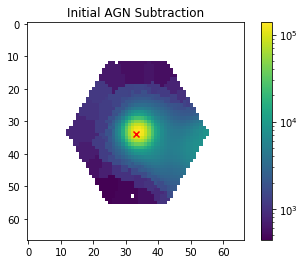

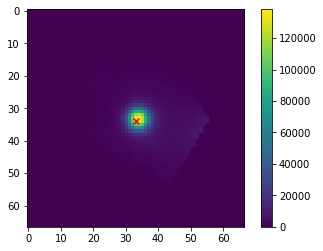

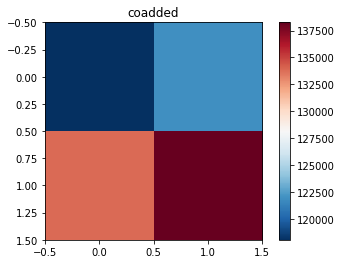

NameError: name 'brightest_spax' is not defined

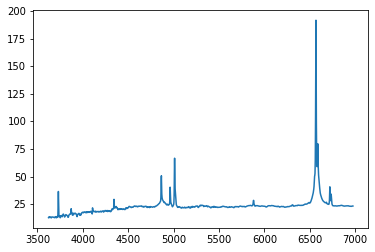

In [94]:
run='fg3_m12'
myr=205
view=1
import os
print(os.getcwd())
# Write this out to file
try:
    hdul = pyfits.HDUList()
    hdul.append(pyfits.PrimaryHDU(data = initial_subtraction))
    hdul.writeto('subtracted/cube_'+str(run)+'_'+str(myr)+'_'+str(view)+'.fits', clobber='True')
except NotImplementedError:
    initial_subtraction.dump('subtracted/cube_'+str(run)+'_'+str(myr)+'_'+str(view)+'.fits')
plt.imshow(np.sum(small[0].data, axis=0), norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.scatter(coords[0][0], coords[0][1], marker='x', color='red')
plt.title('Original Summed Cube')
plt.show()

plt.imshow(np.sum(initial_subtraction, axis=0), norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.scatter(coords[0][0], coords[0][1], marker='x', color='red')
plt.title('Initial AGN Subtraction')
plt.show()

# Select spaxels that are somewhat farther away from the galaxy in the region
# Surrounding the AGN, 8 pixels around it
coadd = initial_subtraction[:,coords[0][0]-1:coords[0][0]+1,coords[0][1]-1:coords[0][1]+1]
coadded = np.sum(coadd, axis=(1,2))/8

plt.imshow(np.sum(small[0].data, axis=0))
plt.colorbar()
plt.scatter(coords[0][0], coords[0][1], marker='x', color='red')
plt.show()

plt.imshow(np.sum(coadd,axis=0), cmap='RdBu_r')
plt.colorbar()
plt.title('coadded')
plt.show()

plt.clf()
plt.plot(cut_manga_wave,coadded, label=r'f$_{host}$, coadded')
plt.plot(cut_manga_wave, brightest_spax, label=r'f$_{QSO, temp}$')
plt.legend()
plt.savefig('before_after.png', dpi=1000)


/Users/beckynevin/CfA_Code/AGN_Subtraction


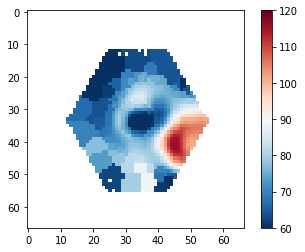

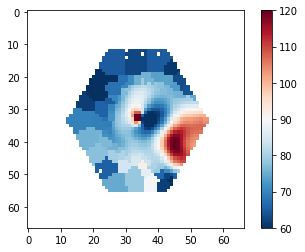

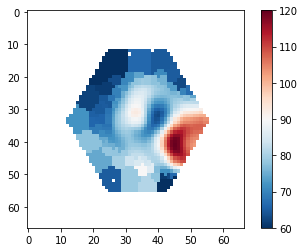

In [114]:
# The next step is to attempt to fit this with ppxf to show that it fails ...
# Alternately, you could just read the velocity cube for comparison
print(os.getcwd())
view=1
vel_maps = pyfits.open('../Kinematics_SUNRISE/kinematic_maps/stellar_kinematics_SCATTER_emline_fg3_m12_205_'+str(view)+'.fits')
vel_2d = ma.masked_where(vel_maps[1].data==0, vel_maps[1].data)
plt.imshow(vel_2d,  cmap='RdBu_r', vmin=60, vmax=120)
plt.colorbar()
plt.show()

view=1
vel_maps = pyfits.open('../Kinematics_SUNRISE/kinematic_maps/stellar_kinematics_SCATTER_emline_AGN_sub_fg3_m12_205_'+str(view)+'.fits')
vel_2d = ma.masked_where(vel_maps[1].data==0, vel_maps[1].data)
plt.imshow(vel_2d,  cmap='RdBu_r', vmin=60, vmax=120)
plt.colorbar()
plt.show()

view=1
vel_maps = pyfits.open('../Kinematics_SUNRISE/kinematic_maps/stellar_kinematics_SCATTER_emline_fg3_m12_agnx0_205_'+str(view)+'.fits')
vel_2d = ma.masked_where(vel_maps[1].data==0, vel_maps[1].data)
plt.imshow(vel_2d,  cmap='RdBu_r', vmin=60, vmax=120)
plt.colorbar()
plt.show()

# So the problem here is that the AGN light is contaminating the entire extent of the galaxy.

(2846,)


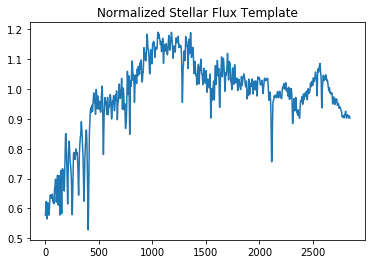

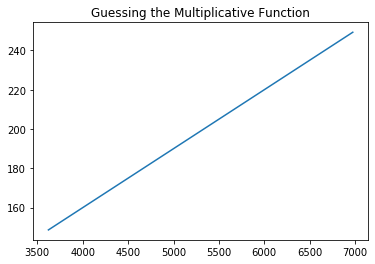

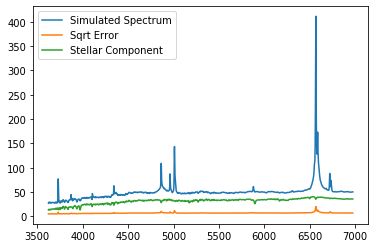

In [10]:
# The first step is to subtract off the stellar continuum in order to determine the shape of the
# contamination from the AGN at the center of the galaxy.

stellar_flux = np.load('model_flux_fg3_m12_205_1.npy', allow_pickle=True)
print(np.shape(stellar_flux))
plt.plot(stellar_flux/np.median(stellar_flux))
plt.title('Normalized Stellar Flux Template')
plt.show()

m_guess=0.03
b_guess=40
fxn = cut_manga_wave*m_guess+b_guess

plt.clf()
plt.plot(cut_manga_wave, fxn)
plt.title('Guessing the Multiplicative Function')
plt.show()

plt.clf()
plt.plot(cut_manga_wave, small[0].data[:,coords[0][0],coords[0][1]], label='Simulated Spectrum')
plt.plot(cut_manga_wave, np.sqrt(small[0].data[:,coords[0][0],coords[0][1]]), label='Sqrt Error')

plt.plot(cut_manga_wave, stellar_flux*fxn, label='Stellar Component')
#plt.axvline(x=cut_manga_wave[1000])

plt.legend()
#plt.ylim([0,50])
plt.show()





32 2
4900.044227932357


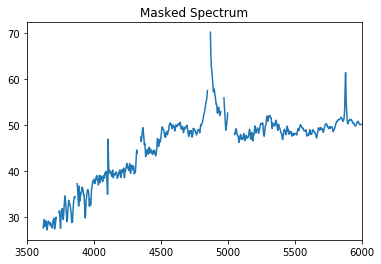

100%|██████████| 500/500 [00:05<00:00, 85.52it/s]


In [34]:
# Do a quick chi-squared fitting to determine what the multiple is to best fit the continuum

# So this would be like multiplying the (normalized) continuum function by a line. m*x + b

# I've also limited this MCMC using the log_prior_neg, which says that subtracting off the
# model stellar template fit cannot return ANY negative numbers.
# My motivation is that the model AGN flux cannot be negative after we subtract off the 
# stellar component.

import emcee
def log_likelihood(theta, x, y, stellar, yerr):
    m, b = theta
    model = (m * x + b)*stellar
    sigma2 = yerr**2 + model**2

    return -0.5*np.sum((y-model)**2)#/sigma2 + np.log(sigma2))
def log_probability(theta, x, y, stellar, yerr):
    lp = log_prior(theta)
    lp_neg = log_prior_neg(theta, y, stellar)
    if not np.isfinite(lp) or not np.isfinite(lp_neg):
        return -np.inf
    return lp + lp_neg + log_likelihood(theta, x, y, stellar, yerr)
def log_prior(theta):
    m, b = theta
    if -0.1 < m < 0.1:
        return 0.0
    return -np.inf
def log_prior_neg(theta, y, stellar):
    m, b = theta
    model = (m * x + b)*stellar
    resid = y - model
    if (resid > 0).all():
        return 0.0
    return -np.inf


m_ml = 0.035
b_ml = 89

# Initialize the walkers to a gaussian cloud around the central guess
pos =  [m_ml, b_ml]+ 1e-2*np.random.randn(32, 2)


nwalkers, ndim = pos.shape
print(nwalkers, ndim)


x = cut_manga_wave
y = small[0].data[:,coords[0][0],coords[0][1]]
yerr = 0.1*small[0].data[:,coords[0][0],coords[0][1]]

# Try masking it to exclude the larger emission lines (this is optional)

print(find_nearest(x, 4900))
x_masked = ma.masked_inside(x, find_nearest(x, 5000), find_nearest(x, 5050))
x_masked = ma.masked_inside(x_masked, find_nearest(x_masked, 6500), find_nearest(x_masked, 6750))
x_masked = ma.masked_inside(x_masked, find_nearest(x_masked, 4850), find_nearest(x_masked, 4870))
x_masked = ma.masked_inside(x_masked, find_nearest(x_masked, 4950), find_nearest(x_masked, 4970))
x_masked = ma.masked_inside(x_masked, find_nearest(x_masked, 3720), find_nearest(x_masked, 3740))
x_masked = ma.masked_inside(x_masked, find_nearest(x_masked, 3860), find_nearest(x_masked, 3875))
x_masked = ma.masked_inside(x_masked, find_nearest(x_masked, 4325), find_nearest(x_masked, 4350))

y_masked = np.ma.masked_where(np.ma.getmask(x_masked), y)

plt.clf()
plt.plot(cut_manga_wave, y_masked)
plt.xlim([3500,6000])
plt.title('Masked Spectrum')
plt.show()


sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, stellar_flux, yerr))
sampler.run_mcmc(pos, 500, progress=True);

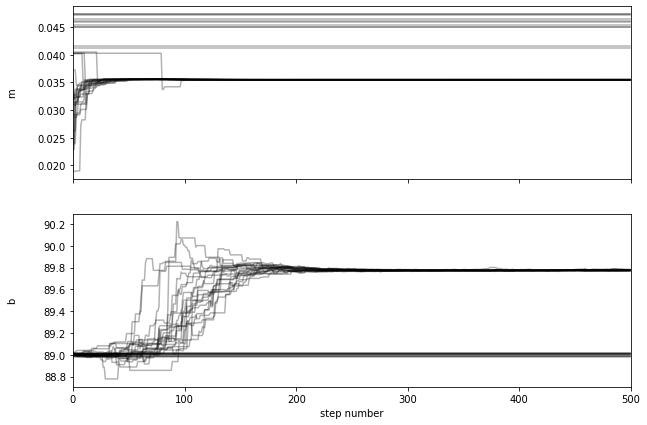

In [35]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
# These plots demonstrate the burn-in period for the chains

<IPython.core.display.Math object>

<IPython.core.display.Math object>

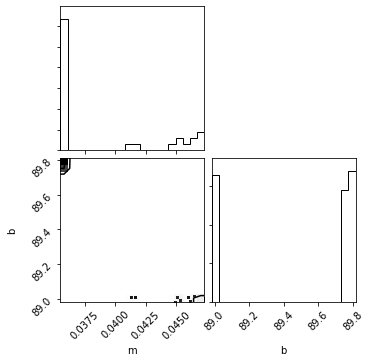

In [36]:
import corner
#tau = sampler.get_autocorr_time()
#print(tau)
flat_samples = sampler.get_chain(discard=200,flat=True)#discard=2000, thin=100, flat=True)
fig = corner.corner(flat_samples, labels=labels);#, truths=[m_true, b_true, np.log(f_true)]);

from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    

# This prints out the values of m and b you should use
# Looks pretty sketchy in the b-m plot.

In [37]:
theta=[0.035, 89.772]
log_probability(theta, x, y_masked, stellar_flux, yerr)

-26622.106306843358

(100, 2846)


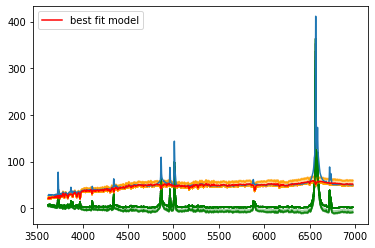

In [38]:
# Plots the best fit stellar spectrum to the central spaxel's spectrum

inds = np.random.randint(len(flat_samples), size=100)
model=[]
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x, small[0].data[:,coords[0][0],coords[0][1]]-stellar_flux*np.dot(np.vander(x, 2), sample[:2]), "g", alpha=0.1)
    plt.plot(x, stellar_flux*np.dot(np.vander(x, 2), sample[:2]), "orange", alpha=0.1)
    model.append(stellar_flux*np.dot(np.vander(x, 2), sample[:2]))
    
plt.plot(x, y);
print(np.shape(model))
plt.plot(x, np.sum(model, axis=0)/100, color='red', label='best fit model');
#plt.ylim([0,70]);
plt.legend();

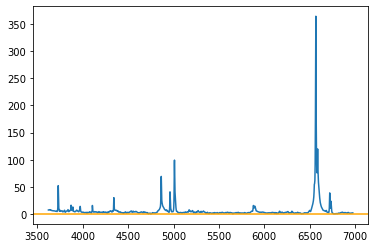

In [42]:
# So after the best fit stellar continuum is determined, it is subtracted off of the AGN continuum in the following
# code blocks

# It is not good to have an over-subtraction here because then you will be having trouble, so figure out how to do
# some sort of masking for the MCMC

# theta=[0.035, 89.772]
plt.plot(x, small[0].data[:,coords[0][0],coords[0][1]] - (0.035*x + 89.772)*stellar_flux)
#np.sum(model, axis=0)/100)
#plt.ylim([-10,10])
plt.axhline(y=0, color='orange')
plt.show()

AGN = small[0].data[:,coords[0][0],coords[0][1]] - (0.035*x + 89.772)*stellar_flux #np.sum(model, axis=0)/100

# So this is the AGN model, convolve it with the spatial PSF model (below)

IndexError: list index out of range

(2846, 67, 67)
(2846, 4489)


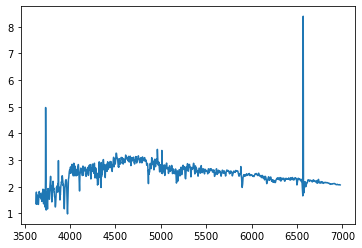

In [582]:
AGN_sub = pyfits.open('subtracted/cube_'+str(run)+'_'+str(myr)+'_'+str(view)+'.fits')
print(np.shape(AGN_sub[0].data))
AGN_sub_data = AGN_sub[0].data


AGN = 'yes'
input_all = AGN_sub_data.reshape(np.shape(AGN_sub_data)[0], np.shape(AGN_sub_data)[1]*np.shape(AGN_sub_data)[2])
print(np.shape(input_all))

plt.plot(cut_manga_wave, AGN_sub_data[:,coords[0][0]-5,coords[0][1]-3])
plt.show()

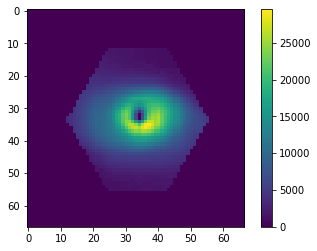

0


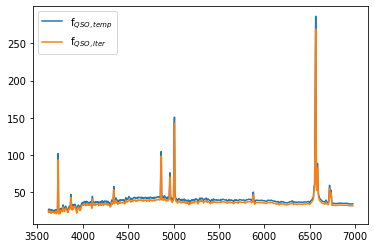

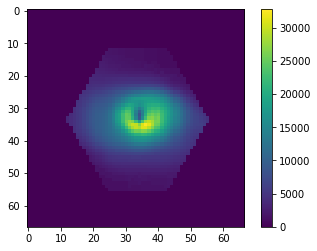

1


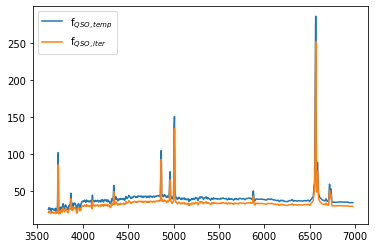

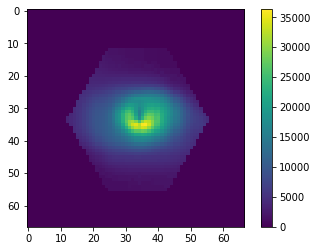

2


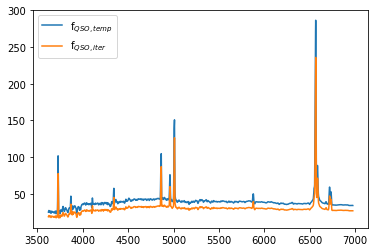

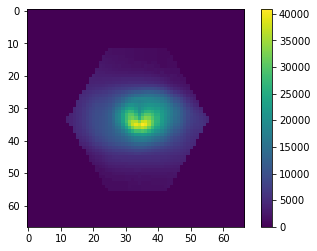

3


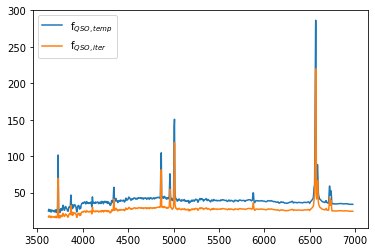

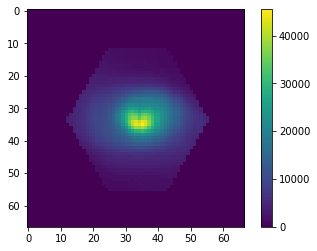

4


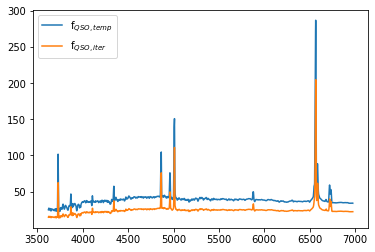

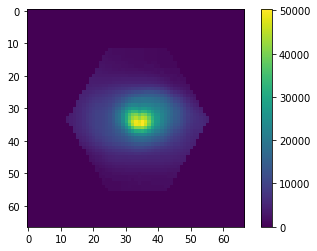

5


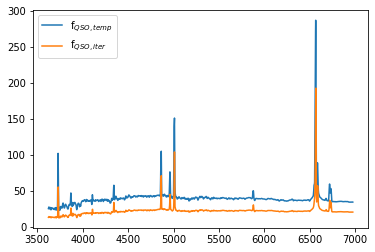

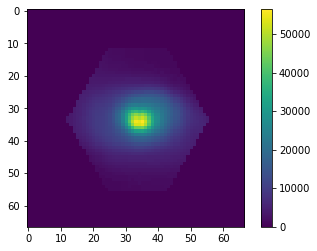

6


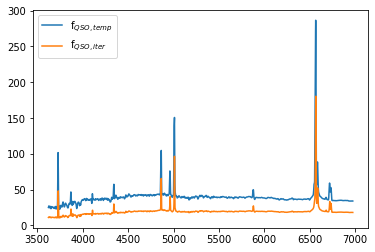

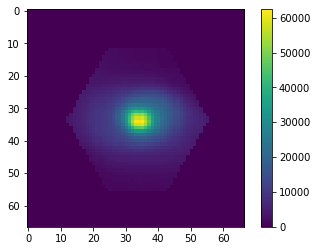

7


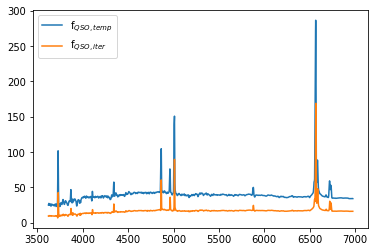

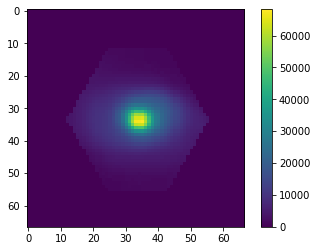

8


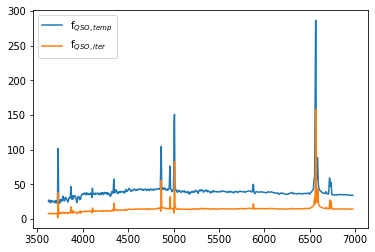

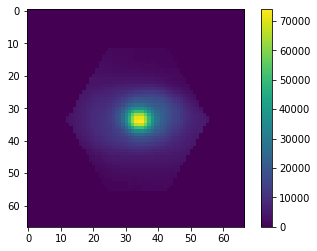

9


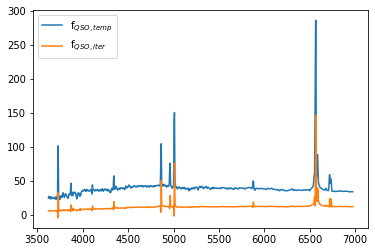

In [377]:
# Now, iteratively subtract the coadded spectrum from the model AGN cube
for i in range(10):
    # Do this until the solution is 'good enough'
    if i ==0:
        empty_gal[:,coords[0][0], coords[0][1]] = brightest_spax#-coadded
    else:
        empty_gal[:,coords[0][0], coords[0][1]] = brightest_spax-coadded

    conv = signal.fftconvolve(kernel, empty_gal[1000,:,:], mode='same')#kernel was gaussian_3D_kernel                             
    #kernel was - gaussian_2D_kernel.array/np.max(gaussian_2D_kernel.array)
    '''plt.imshow(ma.masked_where(conv==0, conv))
    plt.colorbar()
    plt.show()'''

    # Repeat this at each individual wavelength so that you have your model AGN
    AGN_mod = np.zeros((np.shape(small[0].data)[0], np.shape(conv)[1], np.shape(conv)[1]))
    # It is okay that it has larger dimensions

    for j in range(len(cut_manga_wave)):
        AGN_mod[j,:,:] = signal.fftconvolve(kernel, empty_gal[j,:,:], mode='same')#kernel was gaussian_3D_kernel                             
    initial_subtraction = small[0].data - AGN_mod

    plt.imshow(np.sum(initial_subtraction, axis=0))
    plt.colorbar()
    plt.show()

    # Select spaxels that are somewhat farther away from the galaxy in the region
    # Surrounding the AGN, 8 pixels around it
    coadd = initial_subtraction[:,coords[0][0]-1:coords[0][0]+2,coords[0][1]-1:coords[0][1]+2]
    coadded = np.sum(coadd, axis=(1,2))/8

    
    print(i)
    plt.plot(cut_manga_wave,brightest_spax, label=r'f$_{QSO, temp}$')
    plt.plot(cut_manga_wave, brightest_spax-coadded, label=r'f$_{QSO, iter}$')
    plt.legend()
    plt.show()
    
    

In [ ]:
# The next step is to iteratively determine the residual spectrum in some surrounding spaxels



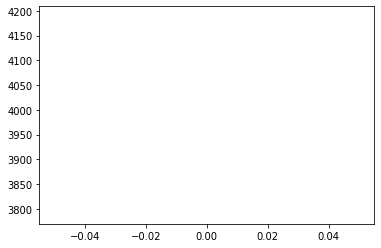

2846
gaussian_3D_kernel (2846, 17, 17)
(1, 17, 17)
(1, 17, 17) (2846,)


<Figure size 432x288 with 0 Axes>

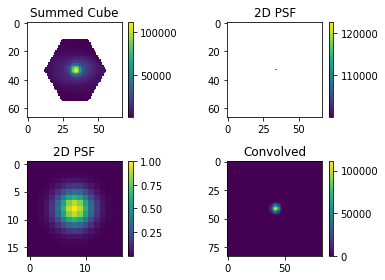

In [109]:
# How to apply this to the correct size?
from scipy import signal

# Create a new map masking everything but the brightest spaxel
new = ma.masked_where(summed_specs<111337, summed_specs)

# I would say try to convolve this whole thing at once
sigma_pix = 0.0001#1/Ang_step#3.5/Ang_step#gives the sigma of the convolution in pixels                               
from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel

gaussian_2D_kernel = gaussian_2D_kernel.array/np.max(gaussian_2D_kernel.array)

gauss_1 = Gaussian1DKernel(sigma_pix)
norm_1D = gauss_1.array/np.max(gauss_1.array)
plt.plot(gauss_1)
plt.show()

gaussian_3D_kernel = np.repeat(gaussian_2D_kernel[np.newaxis,:,:], np.shape(small[0].data)[0], axis=0)
print(np.shape(small[0].data)[0])
print('gaussian_3D_kernel',np.shape(gaussian_3D_kernel))

xs = np.linspace(0, len(gauss_1.array)-1, len(gauss_1.array))
#So now we have a normalized kernel to multiply every dimension of gaussian_3D_kernel by                             
#new = gaussian_3D_kernel*norm_1D[:,np.newaxis,np.newaxis]                                                           
new_3D = np.zeros((len(xs),np.shape(gaussian_3D_kernel)[1],np.shape(gaussian_3D_kernel)[1]))
print(np.shape(new_3D))
for o in range(np.shape(gaussian_3D_kernel)[1]):
    for h in range(np.shape(gaussian_3D_kernel)[1]):
        new_3D[:,o,h] = norm_1D*gaussian_3D_kernel[0,o,h]#instead of norm_1D used to be gauss_1.array                


        
#STOP
empty_gal = np.zeros((np.shape(small[0].data)[0], np.shape(small[0].data)[1], np.shape(small[0].data)[2]))

brightest_spax = small[0].data[:,coords[0][0],coords[0][1]]

empty_gal[:,coords[0][0], coords[0][1]] = brightest_spax

print(np.shape(new_3D), np.shape(brightest_spax))
conv = signal.fftconvolve(new_3D, empty_gal)#kernel was gaussian_3D_kernel                             

plt.clf()
fig = plt.figure()
ax0 = fig.add_subplot(221)
im0 = ax0.imshow(ma.masked_where(summed_specs==0, summed_specs))
plt.colorbar(im0,fraction=0.046, pad=0.04)
ax0.set_title('Summed Cube')

ax1 = fig.add_subplot(222)
im1 = ax1.imshow(new)
plt.colorbar(im1,fraction=0.046, pad=0.04)
ax1.set_title('2D PSF')

ax2 = fig.add_subplot(223)
im2 = ax2.imshow(gaussian_2D_kernel)
plt.colorbar(im2,fraction=0.046, pad=0.04)
ax2.set_title('2D PSF')

ax3 = fig.add_subplot(224)
im3 = ax3.imshow(np.sum(conv, axis=0))#, norm=matplotlib.colors.LogNorm())
plt.colorbar(im3,fraction=0.046, pad=0.04)
ax3.set_title('Convolved')

plt.tight_layout()
plt.show()




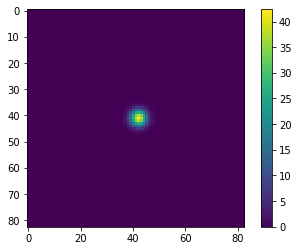

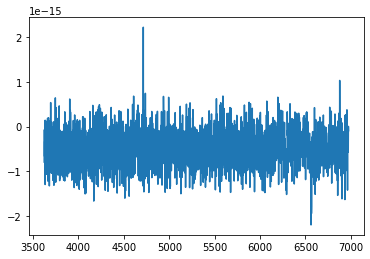

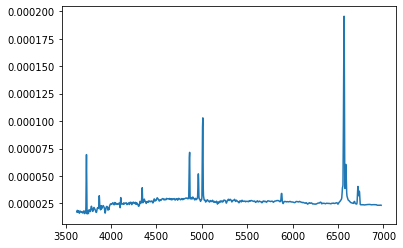

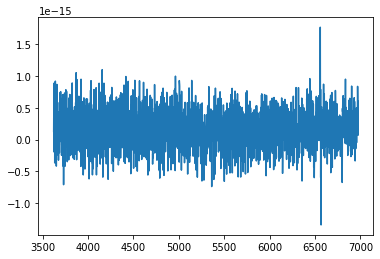

In [112]:
# Now check out what the AGN looks like at different positions
plt.clf()
plt.imshow(conv[1000,:,:])
plt.colorbar()
plt.show()

plt.plot(cut_manga_wave, conv[:,20,20])
plt.show()

plt.plot(cut_manga_wave, conv[:,coords[0][0], coords[0][1]])
plt.show()

plt.plot(cut_manga_wave, conv[:,coords[0][0], coords[0][1]-1])
plt.show()

In [3]:
agnx0 = pyfits.open('mcrx_205_agnx0.fits')
print(agnx0[0].header)

SIMPLE  =                    T / file does conform to FITS standard             BITPIX  =                    8 / number of bits per data pixel                  NAXIS   =                    0 / number of data axes                            EXTEND  =                    T / FITS dataset may contain extensions            COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H FILETYPE= 'TRANSFER'           / File contains output from a radiative transfer DATATYPE= 'GRID    '           / Data is on a grid                              NOBJECT =                    2 / Number of objects contained in this snapshot   SFRCODE = 'SFRHIST '           / See HDU SFRHIST for SFR history calculation setNBODYCOD= 'GADGET  '           / See HDU GADGET for nbody code setup            L-INDEP = 'LAMBDA  '           / See HDU LAMBDA for SED wavelengths             OBJECT  = 'GALAXY  '           / This sn

In [553]:
view = 1
CAMERA0=agnx0[25+view]#25  
Ang=np.array([x[0]*10**(10) for x in agnx0[5].data])
#so I think this is in air wavelengths, we need to convert to vacuum                                                 
s = 10**4/Ang
n = 1 + 0.00008336624212083 + 0.02408926869968 / (130.1065924522 - s**2) + 0.000159740894897 / (38.92568793293 - s**2)
Ang_vac = Ang*n
pixelscale=CAMERA0.header['CD1_1']
kpc_arcmin=cosmo.kpc_proper_per_arcmin(0.03)
sigma = 2.5/2.355    # This is a sigma in arcsec of the seeing, but we want it in pixels
print(kpc_arcmin.value/60, 'kpc/"')
print(pixelscale, 'kpc/pixel')
kernel_sigma_pix = (sigma*(kpc_arcmin.value/60))/pixelscale             
print(kernel_sigma_pix)


0.6067249691915015 kpc/"
0.166666666666667 kpc/pixel
3.8644902496273907


pixelscale 0.166666666666667


Finished processing source 1.

(17, 17) ~~~~~The shape of the 2D kernel~~~~~


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

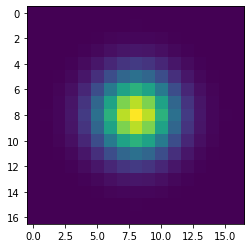

In [478]:
from scipy import ndimage
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
from scipy.ndimage import iterate_structure
from scipy.ndimage.filters import maximum_filter
from scipy import interpolate, fftpack

import scipy.optimize as opt
import statmorph
view = 0
myr=205
run='fg3_m12'
z=0.03
prefix_im='broadband_205_agnx0.fits'
im=pyfits.open(str(prefix_im))
image = im['CAMERA'+str(view)+'-BROADBAND'].data
pixelscale = im['CAMERA'+str(view)+'-BROADBAND'].header['CD1_1']
print('pixelscale', pixelscale)
try:
    broadband = image[64]#[65]#[65]
    broadband_r = image[65]
except IndexError:
    #its these:
    broadband = image[1]#[2]
    broadband_r = image[2]

'''Step 1 is to use the imaging to pull a g-band image and its error image'''
'''The product of this is a S/N image that we will use to make sure the average g-band S/N for the spectrum scales'''

mid_r = get_effective_radius(view,myr,run,broadband_r,pixelscale,z)

half_light_radius = mid_r[6]

mid=get_center(view,myr,run, broadband, pixelscale, z)


mid_x=mid[0]
mid_y=mid[1]
if mid[2]==1:
    '''This means that its flagged'''
    STOP
    #continue


#clip to same size as your g-band image:
try:
    window=CAMERA0.data[:,int(mid_x-mid[3]):int(mid_x+mid[3]),int(mid_y-mid[3]):int(mid_y+mid[3])]
except TypeError:
    STOP
    #continue

Ang = Ang_vac
#first, interpolate to manga data
from scipy.interpolate import griddata


#first take care of the spatial direction by convolving and rebinning

out = window

gaussian_2D_kernel = Gaussian2DKernel(kernel_sigma_pix)  
print(np.shape(gaussian_2D_kernel), '~~~~~The shape of the 2D kernel~~~~~')
plt.clf()
plt.imshow(gaussian_2D_kernel)
plt.show()
#do i need to apply this at every wavelength?                                                                                 
#maybe I can use replicate to make a 3D kernel instead lol                                                                    
gaussian_3D_kernel = np.repeat(gaussian_2D_kernel.array[np.newaxis,:,:], np.shape(out)[0], axis=0)
gaussian_3D_kernel = gaussian_3D_kernel#/np.sum(gaussian_3D_kernel)
from scipy import signal

#Try remaking that first dimension to have some shape

delta = []
for p in range(len(Ang)-1):
    delta.append(Ang[p+1]-Ang[p])

Ang_step = np.median(delta)#this is the size of each step in Ang, which averages around 0.3-0.35AA
#sigma = 72 km s is the median resolution; v/c = delta lam / lam
#1.67AA
#This is 3.5AA on average
sigma_pix = 0.001#1/Ang_step#3.5/Ang_step#gives the sigma of the convolution in pixels
from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel

'''What if we tried making sigma_pix a function of wavelength'''
'''Actually the way to do this is to first interpolate onto a new wavelength scale and
then to do the same width convolution'''
'''So things need to be finer sampled (linearly) starting from the longest wavelengths'''

'''Build a new array'''
new_Ang=[]
for p in range(10*len(Ang)):
    if p==0:
        starting_lambda=Ang[0]
    else:
        starting_lambda=starting_lambda+starting_lambda/2000
    new_Ang.append(starting_lambda)
    if starting_lambda > Ang[-1]:
        break


'''Now remap onto this new weird angstrom scale before you convolve :/'''
input_all_conv = np.reshape(out, (out.shape[0],out.shape[1]*out.shape[2]))
input_all_conv = input_all_conv.T

min_index=np.where(new_Ang==find_nearest(new_Ang,Ang[0]))[0][0]+1
max_index=np.where(new_Ang==find_nearest(new_Ang,Ang[-1]))[0][0]-1
new_Ang_wave=new_Ang[min_index:max_index-1]
int_func = interpolate.interp1d(Ang, input_all_conv)
int_flux = int_func(new_Ang_wave)
int_flux = int_flux.T

ready_conv = np.reshape(int_flux, (int_flux.shape[0], out.shape[1], out.shape[2]))



gauss_1 = Gaussian1DKernel(sigma_pix)
norm_1D = gauss_1.array/np.max(gauss_1.array)

xs = np.linspace(0, len(gauss_1.array)-1, len(gauss_1.array))
#So now we have a normalized kernel to multiply every dimension of gaussian_3D_kernel by
#new = gaussian_3D_kernel*norm_1D[:,np.newaxis,np.newaxis]
new_3D = np.zeros((len(gauss_1.array),np.shape(gaussian_3D_kernel)[1],np.shape(gaussian_3D_kernel)[1]))
for o in range(np.shape(gaussian_3D_kernel)[1]):
    for h in range(np.shape(gaussian_3D_kernel)[1]):
        new_3D[:,o,h] = norm_1D*gaussian_3D_kernel[0,o,h]#instead of norm_1D used to be gauss_1.array



conv = signal.fftconvolve(ready_conv, new_3D, mode='same')#kernel was gaussian_3D_kernel

(1, 67, 67) (1498, 122, 122)


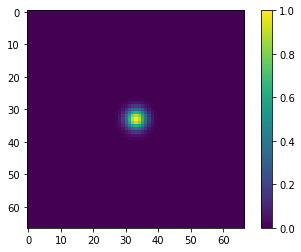

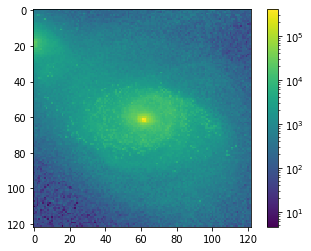

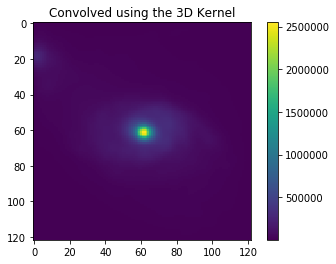

sigma in arcsec 1.0615711252653928 0.5" per pixel 2.1231422505307855
2.1231422505307855


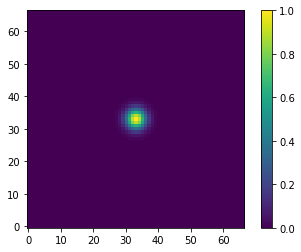

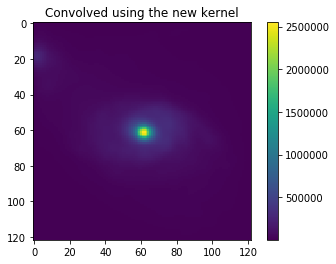

In [482]:
# ~~~~ This is the way you made it in the code:

print(np.shape(new_3D), np.shape(ready_conv))
plt.imshow(np.sum(new_3D, axis=0))
plt.colorbar()
plt.show()

plt.imshow(np.sum(ready_conv, axis=0), norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.show()

plt.imshow(np.sum(conv, axis=0))#, norm=matplotlib.colors.LogNorm())
plt.title('Convolved using the 3D Kernel')
plt.colorbar()
plt.show()


# ~~~~~ And this is the way you're making in this new code:

sigma = 2.5/2.355 #seeing is 2.5" FWHM, meaning that sigma is this many arcsec
# the spaxels are spaced by 0.5"/pix, so sigma is 5 pixels
print('sigma in arcsec', sigma, '0.5" per pixel', sigma/0.5)
kpc_arcmin=cosmo.kpc_proper_per_arcmin(0.03)

kernel_sigma_pix = sigma/0.5
#(sigma*(kpc_arcmin.value/60))/pixelscale                                                         

print(kernel_sigma_pix)
                                                                                                                

kernel = np.outer(signal.gaussian(67,kernel_sigma_pix), signal.gaussian(67, kernel_sigma_pix))
plt.imshow(kernel, interpolation='none', origin='lower')
plt.colorbar()
plt.show()
# try making this one in the same way

gaussian_3D_kernel = np.repeat(kernel[np.newaxis,:,:], np.shape(out)[0], axis=0)
gaussian_3D_kernel = gaussian_3D_kernel#/np.sum(gaussian_3D_kernel)

gauss_1 = Gaussian1DKernel(sigma_pix)
norm_1D = gauss_1.array/np.max(gauss_1.array)

xs = np.linspace(0, len(gauss_1.array)-1, len(gauss_1.array))
#So now we have a normalized kernel to multiply every dimension of gaussian_3D_kernel by
#new = gaussian_3D_kernel*norm_1D[:,np.newaxis,np.newaxis]
new_3D = np.zeros((len(gauss_1.array),np.shape(gaussian_3D_kernel)[1],np.shape(gaussian_3D_kernel)[1]))
for o in range(np.shape(gaussian_3D_kernel)[1]):
    for h in range(np.shape(gaussian_3D_kernel)[1]):
        new_3D[:,o,h] = norm_1D*gaussian_3D_kernel[0,o,h]#instead of norm_1D used to be gauss_1.array



conv = signal.fftconvolve(ready_conv, new_3D, mode='same')#kernel was gaussian_3D_kernel

plt.imshow(np.sum(conv, axis=0))
plt.title('Convolved using the new kernel')
plt.colorbar()
plt.show()

In [460]:
def get_center(view, myr, run, image, pixelscale, z):
    
    x_cen=0
    y_cen=0
    
    
    b=determine_coords(image)
    #this determines the locations of the galaxies

    if b[0]==0:
        #if the first index from determine_coords is zero, the galaxy is out of the image
        #and we can continue and skip this particular image (sometimes other viewpoints of
        #the same snapshot are in the frame so don't get rid of an entire snapshot)
        return 0, 0, 1, 0







    low_pass=b[4]
    num_sol=b[5]

    '''Now, fit a couple 2D gaussians if there are 2 brightest pixels, otherwise
    fit only one 2D gaussian. The output of fit_2_gaussians will be the positions of these
    maxima'''

    if num_sol==1:
        #this is if there's only really one solution because the bulges are too close together
        #fit a 2D gaussian to center the previous guess of peak pixels using the entire surface
        #brightness profile
        c=fit_2_gaussian(b[1],np.shape(image)[0]-b[0],b[1],np.shape(image)[0]-b[0],low_pass)
        if c[8]=='no':
             c=fit_2_gaussian(b[2],np.shape(image)[0]-b[0],b[3],np.shape(image)[0]-b[1],low_pass)

    else:
        c=fit_2_gaussian(b[2],np.shape(image)[0]-b[0],b[3],np.shape(image)[0]-b[1],low_pass)



    if c[4] > c[5]:
        '''this means point 1 is brighter'''
        in_x = c[1]
        in_y = c[0]
        in_2_x = c[3]
        in_2_y = c[2]


    if c[5] > c[4]:
        '''point 2 is the brighter source'''
        in_x = c[3]
        in_y = c[2]
        in_2_x = c[1]
        in_2_y = c[0]




    '''Now place a aperture over each center and figure out which is brighter overall'''
    try:
        
        c_final=determine_brighter(image,  in_y,np.shape(image)[0]-in_x,  in_2_y, np.shape(image)[0]-in_2_x, pixelscale, z)
    except UnboundLocalError:
        return 0, 0, 1, 0
    #if c_final[2]=='yes':
    #    return 0, 0, 1, 0

    if c_final[0] > c_final[1]:
        #Clip the image in the SDSS imaging size around 
        d=clip_image(image, pixelscale, z, int(np.shape(image)[0]-in_x), int(in_y))
        #this means the first aperture (center) is indeed brighter
    else:
        d=clip_image(image, pixelscale, z, int(np.shape(image)[0]-in_2_x), int(in_2_y))

    if d[3]=='no':
        #this means the cutout is outside the image --> bad
        return 0, 0, 1, 0

    x_cen=d[4]
    y_cen=d[5]
    
    if x_cen==0 or y_cen==0:
        flag=1
    else:
        flag=0

    e=nanomags(z, pixelscale, d[0],view, myr, 0.003813)
        
    #Size is determined by what?                                                                                                       
    #arc_size of                                                                                                                       
    #return clipped, size_a, num_pix_half, tag, xcen, ycen
    kpc_arcmin=cosmo.kpc_proper_per_arcmin(z)
    size_a = pixelscale/(kpc_arcmin.value/60)#now we're in "/pix                                                                       
    pix_size = d[2]
    size = int(pix_size*size_a) #now we're in units of " of one side of the thing 

    prep=convolve_rebin_image(myr,z,pixelscale,view, e, size, 1.61, 0.77, 3.73, 3.85, 3.875, 63.711)
    #def convolve_rebin_image(number, z, pixscale, view, counts, size):
    '''The second extension here is the S_N in r-band'''
    plt.clf()
    
    fig=plt.figure()
    ax0=fig.add_subplot(211)
    im0=ax0.imshow(prep[0], norm=matplotlib.colors.LogNorm(), cmap='afmhot_r')
    ax0.set_title('Counts')
    plt.colorbar(im0)
    
    masked_S_N = ma.masked_where(prep[0] < 1, prep[1])
    g_band_signal = ma.masked_where(prep[0] < 1, prep[0])
    g_band_signal = ma.masked_where(np.abs(masked_S_N) < 1, g_band_signal)
    masked_S_N = ma.masked_where(np.abs(masked_S_N) < 1, masked_S_N)
    
    

    ax1=fig.add_subplot(212)
    im1=ax1.imshow(masked_S_N, norm=matplotlib.colors.LogNorm(), cmap='afmhot_r')
    ax1.set_title('S/N')
    plt.colorbar(im1)
    plt.savefig('S_N_g_band_size_check.png')
    
    return x_cen, y_cen, flag, d[2], g_band_signal, masked_S_N#g_band_signal/masked_S_N


def convolve_rebin_image(number, z, pixscale, view, counts, size, sigma_im, sky_mean, sky_std, gain, darkvar, simg):
    #  prep=convolve_rebin_image(myr,e,z,pixelscale,view)
    pixelscale = pixscale
    kpc_arcmin=cosmo.kpc_proper_per_arcmin(z)

    sigma=sigma_im/2.355#this is MaNGA spatial scale (different than SDSS spatial scale)
    kernel_sigma_pix = (sigma*(kpc_arcmin.value/60))/pixscale
    gaussian_2D_kernel = Gaussian2DKernel(kernel_sigma_pix)
    result = (convolve(counts,gaussian_2D_kernel))
    
    factor = (pixelscale/(kpc_arcmin.value/60))/0.5
    
    rebin = scipy.ndimage.zoom(result, factor, order=0)
    
    '''Now, introduce noise'''
    sky_resids_mine_counts=np.random.normal(sky_mean, sky_std, np.shape(rebin))#0.77, 3.73, np.shape(rebin))#0.331132,5.63218,np.shape(nanomaggy))    
    #gain=3.85#4.735                                                                                                                        
    #darkvar=3.875#1.1966                                                                                                                   
    #simg=63.711#121.19590411 #average background value (counts) pre background subraction (used to calculate poisson error)                
    noisy_counts = sky_resids_mine_counts+rebin
    counts_bg=rebin+simg                                                                                                          
    sigma_counts=np.sqrt(counts_bg/gain+darkvar)                                                                                           
    plt.clf()
    fig=plt.figure()
    ax0 = fig.add_subplot(321)
    im0 = ax0.imshow(result, cmap='afmhot_r')
    plt.colorbar(im0)
    ax0.set_title('Convolved')

    ax1 = fig.add_subplot(322)
    im1 = ax1.imshow(rebin, cmap='afmhot_r')
    plt.colorbar(im1)
    ax1.set_title('Rebinned')
    
    ax2 = fig.add_subplot(323)
    im2 = ax2.imshow(noisy_counts, cmap='afmhot_r')
    plt.colorbar(im2)
    ax2.set_title('Noise Added')

    ax3 = fig.add_subplot(324)
    im3 = ax3.imshow(sigma_counts, cmap='afmhot_r')
    plt.colorbar(im3)
    ax3.set_title('Error Image')
    
    ax4 = fig.add_subplot(325)
    im4 = ax4.imshow(noisy_counts/sigma_counts, cmap='jet')
    plt.colorbar(im4)
    ax4.set_title('g-band S/N per spaxel')
    plt.savefig('g_band_image.png')

    
    return noisy_counts, noisy_counts/sigma_counts#S, S/N
    

def nanomags(z, pixscale, camera_data, view, number, cimg):

    c = 299792.458*1000#to get into m/s



    pixelscale=pixscale
    from astropy.cosmology import FlatLambdaCDM
    cosmo = FlatLambdaCDM(H0=70,Om0=0.3)
    d_A = cosmo.comoving_distance(z).value/(1+z)
    #here's a good review of all the different distances cosmology distances:
    #http://www.astro.ufl.edu/~guzman/ast7939/projects/project01.html

    #Convert from specific intensity units (W/m/m^2/sr) from SUNRISE to Janskies (W/Hz/m^2): 
    Janskies=np.array(10**(26)*camera_data*(pixelscale/(1000*d_A))**2*np.pi*((6185.2*10**(-10))**2/c), dtype='>f4')
    #this 1.35e-6 comes from the arcsin(R_sky/Distance to object)
    #the answer needs to be in radians

    #J=10^-26 W/m^2/Hz, so units of flux density
    #reference site: http://www.cv.nrao.edu/course/astr534/Brightness.html
    #We need to go from a spectral brightness (I_nu) which is in m units
    #To a flux density (S_nu) which is in units of Janskies (W/m^2/Hz)

    
    Janskies_bright = Janskies*100**(1/5)

    nanomaggy=Janskies_bright/(3.631*10**(-6))
    '''Now convert into the correct background:)'''

    #nanomaggies and stuff: (Finkbeiner et al. 2004)

    #first, convert to counts (dn) using the average value of cimg from the SDSS frame images
    #dn=img/cimg+simg
    counts=(nanomaggy)/cimg#+simg
    return counts


def clip_image(ins, pixelscale, redshift, xcen, ycen):
 
    kpc_arcmin=cosmo.kpc_proper_per_arcmin(redshift)#insert the redshift  
    #print(kpc_arcmin.value/60, 'kpc per arcsec')
    '''Divide the pixelscale (kpc/pix) by kpc/arcsec to get arcsec
    size of pixels'''
    size_a=pixelscale/(kpc_arcmin.value/60)
    #print('size a in image', size_a)
    num_pix_half=int(17/size_a)
    '''32.5" per diameter is the largest IFU'''
    #print('number of pixels across in image', num_pix_half*2)
    
    
    
    
    if xcen-num_pix_half < 0 or ycen-num_pix_half < 0 or xcen+num_pix_half > 300 or ycen+num_pix_half > 300:
        print('Outside of the box')
        clipped=0
        tag='no'
    
    else:
        #build clipped and centered image
        clipped=(ins[xcen-num_pix_half:xcen+num_pix_half,ycen-num_pix_half:ycen+num_pix_half])
        tag='yes'

 
    
    return clipped, size_a, num_pix_half, tag, xcen, ycen

def determine_brighter(img, x, y, x2, y2, pix, redshift):
    kpc_arcmin=cosmo.kpc_proper_per_arcmin(redshift)#insert the redshift to get the kpc/arcmin scaling

    
    ap_size=(3*(kpc_arcmin.value/60))/pix ###3 arcsec diameter * (kpc/arcsec)   / (kpc/pix) -->
    #This is now in units of pixels
    
    '''step 1: define the circular aperture'''
    positions = [(x, y), (x2, y2)]
    from photutils import CircularAperture,aperture_photometry
    apertures = CircularAperture(positions, ap_size)
    phot_table = aperture_photometry(img, apertures)
    total_light_1=phot_table['aperture_sum'][0]
    total_light_2=phot_table['aperture_sum'][1]

    
    
    masks = apertures.to_mask(method='center')
    mask = masks[0]

    image = mask.to_image(shape=((np.shape(img)[0], np.shape(img)[0])))
    return total_light_1, total_light_2
def twoD_two_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset,
                     amplitude_2, xo_2, yo_2, sigma_x_2, sigma_y_2, theta_2):
    (x, y) = xdata_tuple 
    xo = float(xo)
    yo = float(yo)   
    xo_2 = float(xo_2)
    yo_2 = float(yo_2)  
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    
    a_2 = (np.cos(theta_2)**2)/(2*sigma_x_2**2) + (np.sin(theta_2)**2)/(2*sigma_y_2**2)
    b_2 = -(np.sin(2*theta_2))/(4*sigma_x_2**2) + (np.sin(2*theta_2))/(4*sigma_y_2**2)
    c_2 = (np.sin(theta_2)**2)/(2*sigma_x_2**2) + (np.cos(theta_2)**2)/(2*sigma_y_2**2)
    
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))+ amplitude_2*np.exp( - (a_2*((x-xo_2)**2) + 2*b_2*(x-xo_2)*(y-yo_2) 
                            + c_2*((y-yo_2)**2)))
    
    return g.ravel()
def fit_2_gaussian(x_1,y_1,x_2,y_2, data):
    # Create x and y indices
    data=np.flipud(data)
    x = np.linspace(0, 299, 300)
    y = np.linspace(0, 299, 300)
    x, y = np.meshgrid(x, y)
    

    # add some noise to the data and try to fit the data generated beforehand
    initial_guess = (20,x_1,y_1,7,7,0,10,20,x_2,y_2,7,7,0)#these are good guesses for the units of surface brightness
    data=data.ravel()
    
   
    
    try:
        popt, pcov = opt.curve_fit(twoD_two_Gaussian, (x, y), data, p0=initial_guess)
        fit='yes'
    except RuntimeError:
        popt=[0,0,0,0,0,0,0,0,0,0,0,0,0]
        fit='no'
        #flag for if the fit failed
 
    
    return popt[1], popt[2], popt[8], popt[9], popt[0], popt[7], np.sqrt(popt[3]**2+popt[4]**2), np.sqrt(popt[10]**2+popt[11]**2), fit 

def determine_coords(img):
    
    '''Apply a 10x10 kernal to the image to filter out noise (its basically a low pass filter)
    to smooth things out'''
    kernel = np.ones((10,10))
    

    lp = ndimage.convolve(img, kernel)#was result
    
    
    '''Okay here is where you can filter out the really low stuff
    (anything below 20% of the max is eliminated so that we can detect the peak pixel)'''
    
    max_value=(lp.max())
    low = np.where(lp < 0.2*max_value)
    
   
    lp[low] = 0
    
    
    
    
    
    
    '''Detects brightest peaks in an image (can detect more than 1)'''
    indices = np.where(detect_peaks(lp) == 1)#was hp_lp_sharp
    
    number_of_sols=len(indices[0])
    
    
    try:
        return indices[0][0],indices[0][-1],indices[1][0],indices[1][-1], lp, number_of_sols
    except IndexError:
        #if there are no peaks this means the simulation was somehow cut off and
        #starting with returning zeros will flag the entire procedure to continue
        #without further ado
        return 0,0,0,0,lp,number_of_sols


def detect_peaks(image):
    """                                                                                                                                                                                                         
    Takes an image and detect the peaks using the local maximum filter.                                                                                                                                         
    Returns a boolean mask of the peaks (i.e. 1 when                                                                                                                                                            
    the pixel's value is the neighborhood maximum, 0 otherwise)                                                                                                                                                 
    """

    # define an 8-connected neighborhood                                                                                                                                                                        
    struct = generate_binary_structure(2,1)

    neighborhood = iterate_structure(struct, 10).astype(bool)

    #apply the local maximum filter; all pixel of maximal value                                                                                                                                                 
    #in their neighborhood are set to 1                                                                                                                                                                         
    local_max = maximum_filter(image, footprint=neighborhood)==image
    #local_max is a mask that contains the peaks we are                                                                                                                                                         
    #looking for, but also the background.                                                                                                                                                                      
    #In order to isolate the peaks we must remove the background from the mask.                                                                                                                                 


    #we create the mask of the background                                                                                                                                                                       
    background = (image==0)

    #a little technicality: we must erode the background in order to                                                                                                                                            
    #successfully subtract it form local_max, otherwise a line will                                                                                                                                             
    #appear along the background border (artifact of the local maximum filter)                                                                                                                                  
    eroded_background = binary_erosion(background, structure=neighborhood, border_value=1)

    #we obtain the final mask, containing only peaks,                                                                                                                                                           
    #by removing the background from the local_max mask (xor operation)                                                                                                                                         
    detected_peaks = local_max ^ eroded_background

    return detected_peaks

def get_effective_radius(view, myr, run, image, pixelscale, z):

    x_cen=0
    y_cen=0


    b=determine_coords(image)
    #this determines the locations of the galaxies                                                                                                                                                          

    if b[0]==0:
        #if the first index from determine_coords is zero, the galaxy is out of the image                                                                                                                   
        #and we can continue and skip this particular image (sometimes other viewpoints of                                                                                                                  
        #the same snapshot are in the frame so don't get rid of an entire snapshot)                                                                                                                         
        return 0, 0, 1, 0, 0, 0, 0







    low_pass=b[4]
    num_sol=b[5]

    '''Now, fit a couple 2D gaussians if there are 2 brightest pixels, otherwise                                                                                                                            
    fit only one 2D gaussian. The output of fit_2_gaussians will be the positions of these                                                                                                                  
    maxima'''

    if num_sol==1:
        #this is if there's only really one solution because the bulges are too close together                                                                                                              
        #fit a 2D gaussian to center the previous guess of peak pixels using the entire surface                                                                                                             
        #brightness profile                                                                                                                                                                                 
        c=fit_2_gaussian(b[1],np.shape(image)[0]-b[0],b[1],np.shape(image)[0]-b[0],low_pass)
        if c[8]=='no':
             c=fit_2_gaussian(b[2],np.shape(image)[0]-b[0],b[3],np.shape(image)[0]-b[1],low_pass)

    else:
        c=fit_2_gaussian(b[2],np.shape(image)[0]-b[0],b[3],np.shape(image)[0]-b[1],low_pass)



    if c[4] > c[5]:
        '''this means point 1 is brighter'''
        in_x = c[1]
        in_y = c[0]
        in_2_x = c[3]
        in_2_y = c[2]


    if c[5] > c[4]:
        '''point 2 is the brighter source'''
        in_x = c[3]
        in_y = c[2]
        in_2_x = c[1]
        in_2_y = c[0]




    '''Now place a aperture over each center and figure out which is brighter overall'''
    try:
        c_final=determine_brighter(image,  in_y,np.shape(image)[0]-in_x,  in_2_y, np.shape(image)[0]-in_2_x, pixelscale, z)
    except UnboundLocalError:
        return 0, 0, 1, 0, 0, 0, 0
    #if c_final[2]=='yes':                                                                                                                                                                                  
    #    return 0, 0, 1, 0                                                                                                                                                                                  

    if c_final[0] > c_final[1]:
        #Clip the image in the SDSS imaging size around                                                                                                                                                     
        d=clip_image(image, pixelscale, z, int(np.shape(image)[0]-in_x), int(in_y))
        #this means the first aperture (center) is indeed brighter                                                                                                                                          
    else:
        d=clip_image(image, pixelscale, z, int(np.shape(image)[0]-in_2_x), int(in_2_y))

    if d[3]=='no':
        #this means the cutout is outside the image --> bad                                                                                                                                                 
        return 0, 0, 1, 0, 0, 0, 0

    x_cen=d[4]
    y_cen=d[5]

    if x_cen==0 or y_cen==0:
        flag=1
    else:
        flag=0

    e=nanomags(z, pixelscale, d[0],view, myr, 0.005005)

    #Size is determined by what?                                                                                                                                                                            
    #arc_size of                                                                                                                                                                                            
    #return clipped, size_a, num_pix_half, tag, xcen, ycen                                                                                                                                 v                 
    kpc_arcmin=cosmo.kpc_proper_per_arcmin(z)
    size_a = pixelscale/(kpc_arcmin.value/60)#now we're in "/pix                                                                                                                                            
    pix_size = d[2]
    size = int(pix_size*size_a) #now we're in units of " of one side of the thing                                                                                                                           

    prep=convolve_rebin_image(myr,z,pixelscale,view, e, size, 1.43, 0.33, 5.63, 4.735, 1.1966, 121.1959)
    #def convolve_rebin_image(number, z, pixscale, view, counts, size):                                                                                                                                     
    '''The second extension here is the S_N in r-band'''
    plt.clf()


    masked_S_N = ma.masked_where(prep[0] < 1, prep[1])
    g_band_signal = ma.masked_where(prep[0] < 1, prep[0])
    masked_S_N = ma.masked_where(np.abs(masked_S_N) < 1, masked_S_N)




    '''Now use statmorph to get the half light radius'''
    import photutils
    import scipy.ndimage as ndi
    threshold = photutils.detect_threshold(g_band_signal, error=g_band_signal/masked_S_N, snr=10)#, snr=1.5)
    npixels = 5  # minimum number of connected pixels
    segm = photutils.detect_sources(g_band_signal, threshold, npixels)

    label = np.argmax(segm.areas) + 1
    segmap = segm.data == label

    segmap_float = ndi.uniform_filter(np.float64(segmap), size=10)
    segmap = segmap_float > 0.5

    source_morphs = statmorph.source_morphology(g_band_signal, segmap, weightmap=masked_S_N)#, gain=gain, psf=psf)

    try:
        morph = source_morphs[0]
 
    except IndexError:
        threshold = photutils.detect_threshold(g_band_signal, error=g_band_signal/masked_S_N, snr=100)#, snr=1.5)                                                                                           
        npixels = 5  # minimum number of connected pixels                                                                                                                                                  
        segm = photutils.detect_sources(g_band_signal, threshold, npixels)

        label = np.argmax(segm.areas) + 1
        segmap = segm.data == label

        segmap_float = ndi.uniform_filter(np.float64(segmap), size=10)
        segmap = segmap_float > 0.5

        source_morphs = statmorph.source_morphology(g_band_signal, segmap, weightmap=masked_S_N)#, gain=gain, psf=psf)            
        try:
            morph = source_morphs[0]
        except IndexError:
            threshold = photutils.detect_threshold(g_band_signal, error=g_band_signal/masked_S_N, snr=1)
                                                                                                                             
            npixels = 5  # minimum number of connected pixels                                                               
                                                                                                                                
            segm = photutils.detect_sources(g_band_signal, threshold, npixels)

            label = np.argmax(segm.areas) + 1
            segmap = segm.data == label

            segmap_float = ndi.uniform_filter(np.float64(segmap), size=10)
            segmap = segmap_float > 0.5

            source_morphs = statmorph.source_morphology(g_band_signal, segmap, weightmap=masked_S_N)#, gain=gain, psf=psf)   
            try:
                morph = source_morphs[0]
            except IndexError:
                segmap = np.ones((np.shape(g_band_signal)[0], np.shape(g_band_signal)[1]))
                source_morphs = statmorph.source_morphology(g_band_signal, segmap, weightmap=masked_S_N)
                morph = source_morphs[0]
    return x_cen, y_cen, flag, d[2], g_band_signal, masked_S_N, morph.rhalf_ellip, morph.sersic_ellip, morph.sersic_theta#g_band_signal/masked_S_N      
